In [1]:
# Libraries
import tensorflow
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, ConcatDataset
from transformers import AutoTokenizer, BertTokenizer 

import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sn
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from ABSA_SentimentMultiEmiten.model.bert import bert_ABSA
from ABSA_SentimentMultiEmiten.data.dataset import dataset_ABSA

2023-06-03 13:20:49.565427: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
# Menentukan device yang akan digunakan untuk melakukan komputasi
DEVICE = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

print("Tensorflow\t: ", tensorflow.__version__)
print("Torch\t\t: ", torch.__version__)
print("Device\t\t: ", DEVICE)
print("GPU\t\t: ", torch.cuda.get_device_name())
print("CUDA\t\t: ", torch.version.cuda)

Tensorflow	:  2.4.1
Torch		:  1.4.0
Device		:  cuda:2
GPU		:  Tesla T4
CUDA		:  10.1


In [3]:
# Inisialisasi hyperparameter
bs = 8
lr = 0.00002
epoch = 8

In [4]:
# Inisialisasi pre-trained model IndoBERT
pretrained_model_name = "indobenchmark/indobert-base-p1"
model_name = "indonlu-indobert.pkl"
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)
model_ABSA = bert_ABSA(pretrained_model_name)
model_ABSA.to(DEVICE)
optimizer_ABSA = torch.optim.Adam(model_ABSA.parameters(), lr=lr)

In [5]:
# Function untuk konversi waktu dari detik ke jam, menit, detik
def evl_time(t):
    min, sec= divmod(t, 60)
    hr, min = divmod(min, 60)
    return int(hr), int(min), int(sec)

# Function untuk menyimpan model
def save_model(model, name):
    torch.save(model.state_dict(), name)

# Function untuk load model
def load_model(model, path):
    model.load_state_dict(torch.load(path), strict=False)
    return model

In [6]:
# Mengubah dataset menjadi beberapa mini-batch
def create_mini_batch(samples):
    ids_tensors = [s[1] for s in samples]
    ids_tensors = pad_sequence(ids_tensors, batch_first=True)

    segments_tensors = [s[2] for s in samples]
    segments_tensors = pad_sequence(segments_tensors, batch_first=True)

    label_ids = torch.stack([s[3] for s in samples])
    
    masks_tensors = torch.zeros(ids_tensors.shape, dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(ids_tensors != 0, 1)

    return ids_tensors, segments_tensors, masks_tensors, label_ids

In [7]:
# Function untuk pelatihan model
def train_model_ABSA(loader, epochs, model_name):
    history = {'loss' : []}
    all_data = len(loader)
    
    # Pengulangan epoch
    for epoch in range(epochs):
        finish_data = 0
        losses = []
        current_times = []
        
        # Pengulangan setiap mini-batch
        for data in loader:
            t0 = time.time()
            ids_tensors, segments_tensors, masks_tensors, label_ids = data
            ids_tensors = ids_tensors.to(DEVICE)
            segments_tensors = segments_tensors.to(DEVICE)
            label_ids = label_ids.to(DEVICE)
            masks_tensors = masks_tensors.to(DEVICE)

            loss = model_ABSA(ids_tensors=ids_tensors, lable_tensors=label_ids, masks_tensors=masks_tensors, segments_tensors=segments_tensors)
            losses.append(loss.item())
            loss.backward()
            optimizer_ABSA.step()
            optimizer_ABSA.zero_grad()

            finish_data += 1
            current_times.append(round(time.time()-t0,3))
            current = np.mean(current_times)
            hr, min, sec = evl_time(current*(all_data-finish_data) + current*all_data*(epochs-epoch-1))
            print('epoch:', epoch+1, "/" , epochs," batch:", finish_data, "/" , all_data, " loss:", np.mean(losses), " hr:", hr, " min:", min," sec:", sec)

        history['loss'].append(np.mean(losses))
        save_model(model_ABSA, model_name)
    
    return history

# Function untuk pengujian model
def test_model_ABSA(loader):
    pred = []
    truth = []
    
    with torch.no_grad():
        # Pengulangan setiap mini-batch
        for data in loader:
            ids_tensors, segments_tensors, masks_tensors, label_ids = data
            ids_tensors = ids_tensors.to(DEVICE)
            segments_tensors = segments_tensors.to(DEVICE)
            masks_tensors = masks_tensors.to(DEVICE)

            outputs = model_ABSA(ids_tensors, None, masks_tensors=masks_tensors, segments_tensors=segments_tensors)
            
            _, predictions = torch.max(outputs, dim=1)

            pred += list([int(i) for i in predictions])
            truth += list([int(i) for i in label_ids])

    return truth, pred

In [8]:
# Function untuk menampilkan confusion matrix
def draw_c_matrix(c_matrix, title="test"):
    aix = []
    
    for y in range(len(c_matrix)):
        aix.append(y)
    df_cm = pd.DataFrame(c_matrix, aix, aix)
    sn.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')
    plt.ylabel("prediction")
    plt.xlabel("ground truth")
    plt.title(title)
    plt.show()

In [9]:
# Inisialisasi dataset
emiten_train_ds = dataset_ABSA(pd.read_csv("data_experiment/data_balance_experiment_training.csv"), tokenizer)
emiten_test_ds = dataset_ABSA(pd.read_csv("data_experiment/data_balance_experiment_testing.csv"), tokenizer)

train_ds = ConcatDataset([emiten_train_ds])
test_ds = ConcatDataset([emiten_test_ds])

# Mengubah dataset menjadi mini-batch
train_loader = DataLoader(train_ds, batch_size=bs, collate_fn=create_mini_batch, shuffle = True)
test_loader = DataLoader(test_ds, batch_size=bs, collate_fn=create_mini_batch, shuffle = True)

In [10]:
# Proses training model
history = %time train_model_ABSA(train_loader, epoch, model_name)

epoch: 1 / 8  batch: 1 / 1224  loss: 1.2008649110794067  hr: 0  min: 52  sec: 42
epoch: 1 / 8  batch: 2 / 1224  loss: 1.190506637096405  hr: 0  min: 47  sec: 53
epoch: 1 / 8  batch: 3 / 1224  loss: 1.1510799328486125  hr: 0  min: 37  sec: 24
epoch: 1 / 8  batch: 4 / 1224  loss: 1.1792835891246796  hr: 0  min: 32  sec: 27
epoch: 1 / 8  batch: 5 / 1224  loss: 1.2140010118484497  hr: 0  min: 32  sec: 39
epoch: 1 / 8  batch: 6 / 1224  loss: 1.2321656545003254  hr: 0  min: 29  sec: 52
epoch: 1 / 8  batch: 7 / 1224  loss: 1.249970725604466  hr: 0  min: 30  sec: 31
epoch: 1 / 8  batch: 8 / 1224  loss: 1.2204891443252563  hr: 0  min: 31  sec: 1
epoch: 1 / 8  batch: 9 / 1224  loss: 1.2081354061762493  hr: 0  min: 29  sec: 40
epoch: 1 / 8  batch: 10 / 1224  loss: 1.225978147983551  hr: 0  min: 28  sec: 18
epoch: 1 / 8  batch: 11 / 1224  loss: 1.2185458811846646  hr: 0  min: 28  sec: 49
epoch: 1 / 8  batch: 12 / 1224  loss: 1.1945737451314926  hr: 0  min: 28  sec: 24
epoch: 1 / 8  batch: 13 / 122

epoch: 1 / 8  batch: 102 / 1224  loss: 0.93201670868724  hr: 0  min: 29  sec: 4
epoch: 1 / 8  batch: 103 / 1224  loss: 0.932596482119514  hr: 0  min: 29  sec: 8
epoch: 1 / 8  batch: 104 / 1224  loss: 0.9325163410260127  hr: 0  min: 29  sec: 12
epoch: 1 / 8  batch: 105 / 1224  loss: 0.9280162822632563  hr: 0  min: 29  sec: 16
epoch: 1 / 8  batch: 106 / 1224  loss: 0.9251507070829283  hr: 0  min: 29  sec: 19
epoch: 1 / 8  batch: 107 / 1224  loss: 0.9230039849459568  hr: 0  min: 29  sec: 16
epoch: 1 / 8  batch: 108 / 1224  loss: 0.9203387040782858  hr: 0  min: 29  sec: 8
epoch: 1 / 8  batch: 109 / 1224  loss: 0.9161633110921318  hr: 0  min: 29  sec: 10
epoch: 1 / 8  batch: 110 / 1224  loss: 0.9115013946186412  hr: 0  min: 29  sec: 3
epoch: 1 / 8  batch: 111 / 1224  loss: 0.9124124447504679  hr: 0  min: 29  sec: 6
epoch: 1 / 8  batch: 112 / 1224  loss: 0.9108853531735284  hr: 0  min: 29  sec: 9
epoch: 1 / 8  batch: 113 / 1224  loss: 0.9083217825509805  hr: 0  min: 29  sec: 12
epoch: 1 / 8 

epoch: 1 / 8  batch: 202 / 1224  loss: 0.8125038644169816  hr: 0  min: 29  sec: 20
epoch: 1 / 8  batch: 203 / 1224  loss: 0.8141167147699835  hr: 0  min: 29  sec: 26
epoch: 1 / 8  batch: 204 / 1224  loss: 0.8117111927154017  hr: 0  min: 29  sec: 27
epoch: 1 / 8  batch: 205 / 1224  loss: 0.8112176755579507  hr: 0  min: 29  sec: 28
epoch: 1 / 8  batch: 206 / 1224  loss: 0.809486660853173  hr: 0  min: 29  sec: 30
epoch: 1 / 8  batch: 207 / 1224  loss: 0.8084049216215161  hr: 0  min: 29  sec: 32
epoch: 1 / 8  batch: 208 / 1224  loss: 0.8067483661266474  hr: 0  min: 29  sec: 33
epoch: 1 / 8  batch: 209 / 1224  loss: 0.8045483117468619  hr: 0  min: 29  sec: 30
epoch: 1 / 8  batch: 210 / 1224  loss: 0.8036638296785809  hr: 0  min: 29  sec: 32
epoch: 1 / 8  batch: 211 / 1224  loss: 0.8014797571146093  hr: 0  min: 29  sec: 28
epoch: 1 / 8  batch: 212 / 1224  loss: 0.8025403146473866  hr: 0  min: 29  sec: 30
epoch: 1 / 8  batch: 213 / 1224  loss: 0.8026631989389518  hr: 0  min: 29  sec: 26
epoch

epoch: 1 / 8  batch: 302 / 1224  loss: 0.7274300083518028  hr: 0  min: 29  sec: 13
epoch: 1 / 8  batch: 303 / 1224  loss: 0.7274091728154582  hr: 0  min: 29  sec: 10
epoch: 1 / 8  batch: 304 / 1224  loss: 0.7270592906463303  hr: 0  min: 29  sec: 12
epoch: 1 / 8  batch: 305 / 1224  loss: 0.7286030679941178  hr: 0  min: 29  sec: 11
epoch: 1 / 8  batch: 306 / 1224  loss: 0.7293744249378934  hr: 0  min: 29  sec: 12
epoch: 1 / 8  batch: 307 / 1224  loss: 0.7282882135252222  hr: 0  min: 29  sec: 13
epoch: 1 / 8  batch: 308 / 1224  loss: 0.7290868718999547  hr: 0  min: 29  sec: 14
epoch: 1 / 8  batch: 309 / 1224  loss: 0.7277697386961539  hr: 0  min: 29  sec: 18
epoch: 1 / 8  batch: 310 / 1224  loss: 0.7266140337432584  hr: 0  min: 29  sec: 19
epoch: 1 / 8  batch: 311 / 1224  loss: 0.7255783688121287  hr: 0  min: 29  sec: 17
epoch: 1 / 8  batch: 312 / 1224  loss: 0.7247371114312838  hr: 0  min: 29  sec: 18
epoch: 1 / 8  batch: 313 / 1224  loss: 0.725103217430008  hr: 0  min: 29  sec: 15
epoch

epoch: 1 / 8  batch: 401 / 1224  loss: 0.6741607455987288  hr: 0  min: 29  sec: 9
epoch: 1 / 8  batch: 402 / 1224  loss: 0.6739051904696137  hr: 0  min: 29  sec: 10
epoch: 1 / 8  batch: 403 / 1224  loss: 0.6734594764839626  hr: 0  min: 29  sec: 11
epoch: 1 / 8  batch: 404 / 1224  loss: 0.6732493407360398  hr: 0  min: 29  sec: 12
epoch: 1 / 8  batch: 405 / 1224  loss: 0.6721938209401237  hr: 0  min: 29  sec: 13
epoch: 1 / 8  batch: 406 / 1224  loss: 0.6731932914535987  hr: 0  min: 29  sec: 11
epoch: 1 / 8  batch: 407 / 1224  loss: 0.6736683703098602  hr: 0  min: 29  sec: 14
epoch: 1 / 8  batch: 408 / 1224  loss: 0.6741069107882532  hr: 0  min: 29  sec: 12
epoch: 1 / 8  batch: 409 / 1224  loss: 0.6727869788635622  hr: 0  min: 29  sec: 13
epoch: 1 / 8  batch: 410 / 1224  loss: 0.6726043551069935  hr: 0  min: 29  sec: 11
epoch: 1 / 8  batch: 411 / 1224  loss: 0.6735085873635726  hr: 0  min: 29  sec: 12
epoch: 1 / 8  batch: 412 / 1224  loss: 0.6726467906343705  hr: 0  min: 29  sec: 10
epoch

epoch: 1 / 8  batch: 502 / 1224  loss: 0.6541599278371647  hr: 0  min: 29  sec: 4
epoch: 1 / 8  batch: 503 / 1224  loss: 0.6531917165157572  hr: 0  min: 29  sec: 4
epoch: 1 / 8  batch: 504 / 1224  loss: 0.6528572811789456  hr: 0  min: 29  sec: 2
epoch: 1 / 8  batch: 505 / 1224  loss: 0.6527426904085839  hr: 0  min: 29  sec: 0
epoch: 1 / 8  batch: 506 / 1224  loss: 0.6518898236421728  hr: 0  min: 29  sec: 1
epoch: 1 / 8  batch: 507 / 1224  loss: 0.6510499027471336  hr: 0  min: 29  sec: 1
epoch: 1 / 8  batch: 508 / 1224  loss: 0.6506852477084933  hr: 0  min: 28  sec: 59
epoch: 1 / 8  batch: 509 / 1224  loss: 0.6496883633680101  hr: 0  min: 29  sec: 0
epoch: 1 / 8  batch: 510 / 1224  loss: 0.6499525833947986  hr: 0  min: 29  sec: 2
epoch: 1 / 8  batch: 511 / 1224  loss: 0.6491170941383638  hr: 0  min: 29  sec: 1
epoch: 1 / 8  batch: 512 / 1224  loss: 0.6482781020167749  hr: 0  min: 29  sec: 0
epoch: 1 / 8  batch: 513 / 1224  loss: 0.6476347185889183  hr: 0  min: 29  sec: 0
epoch: 1 / 8  b

epoch: 1 / 8  batch: 602 / 1224  loss: 0.6316163364636938  hr: 0  min: 28  sec: 50
epoch: 1 / 8  batch: 603 / 1224  loss: 0.6314194569144874  hr: 0  min: 28  sec: 50
epoch: 1 / 8  batch: 604 / 1224  loss: 0.6307106951115936  hr: 0  min: 28  sec: 50
epoch: 1 / 8  batch: 605 / 1224  loss: 0.6311060770976642  hr: 0  min: 28  sec: 51
epoch: 1 / 8  batch: 606 / 1224  loss: 0.6314358885827238  hr: 0  min: 28  sec: 53
epoch: 1 / 8  batch: 607 / 1224  loss: 0.6312093076340646  hr: 0  min: 28  sec: 53
epoch: 1 / 8  batch: 608 / 1224  loss: 0.6308611600512737  hr: 0  min: 28  sec: 54
epoch: 1 / 8  batch: 609 / 1224  loss: 0.6302282813392054  hr: 0  min: 28  sec: 54
epoch: 1 / 8  batch: 610 / 1224  loss: 0.6304484706677375  hr: 0  min: 28  sec: 55
epoch: 1 / 8  batch: 611 / 1224  loss: 0.6300523304266157  hr: 0  min: 28  sec: 55
epoch: 1 / 8  batch: 612 / 1224  loss: 0.6297499251862367  hr: 0  min: 28  sec: 55
epoch: 1 / 8  batch: 613 / 1224  loss: 0.6296917728800174  hr: 0  min: 28  sec: 56
epoc

epoch: 1 / 8  batch: 701 / 1224  loss: 0.6062072364137788  hr: 0  min: 28  sec: 33
epoch: 1 / 8  batch: 702 / 1224  loss: 0.6065757835013235  hr: 0  min: 28  sec: 34
epoch: 1 / 8  batch: 703 / 1224  loss: 0.6059212611715281  hr: 0  min: 28  sec: 34
epoch: 1 / 8  batch: 704 / 1224  loss: 0.6054069434123283  hr: 0  min: 28  sec: 34
epoch: 1 / 8  batch: 705 / 1224  loss: 0.6047411881017347  hr: 0  min: 28  sec: 35
epoch: 1 / 8  batch: 706 / 1224  loss: 0.6045826868953516  hr: 0  min: 28  sec: 35
epoch: 1 / 8  batch: 707 / 1224  loss: 0.6039318447192286  hr: 0  min: 28  sec: 35
epoch: 1 / 8  batch: 708 / 1224  loss: 0.6034400008703019  hr: 0  min: 28  sec: 37
epoch: 1 / 8  batch: 709 / 1224  loss: 0.6031017517211239  hr: 0  min: 28  sec: 39
epoch: 1 / 8  batch: 710 / 1224  loss: 0.6024672366154026  hr: 0  min: 28  sec: 39
epoch: 1 / 8  batch: 711 / 1224  loss: 0.6018935240354552  hr: 0  min: 28  sec: 39
epoch: 1 / 8  batch: 712 / 1224  loss: 0.6018081216581082  hr: 0  min: 28  sec: 38
epoc

epoch: 1 / 8  batch: 800 / 1224  loss: 0.5863187923282385  hr: 0  min: 28  sec: 30
epoch: 1 / 8  batch: 801 / 1224  loss: 0.5856680424509573  hr: 0  min: 28  sec: 29
epoch: 1 / 8  batch: 802 / 1224  loss: 0.5852695743081873  hr: 0  min: 28  sec: 29
epoch: 1 / 8  batch: 803 / 1224  loss: 0.584686704174816  hr: 0  min: 28  sec: 29
epoch: 1 / 8  batch: 804 / 1224  loss: 0.5846849212895578  hr: 0  min: 28  sec: 29
epoch: 1 / 8  batch: 805 / 1224  loss: 0.5850890254382021  hr: 0  min: 28  sec: 28
epoch: 1 / 8  batch: 806 / 1224  loss: 0.5844346740220676  hr: 0  min: 28  sec: 27
epoch: 1 / 8  batch: 807 / 1224  loss: 0.5840968813705621  hr: 0  min: 28  sec: 28
epoch: 1 / 8  batch: 808 / 1224  loss: 0.5836756331753907  hr: 0  min: 28  sec: 28
epoch: 1 / 8  batch: 809 / 1224  loss: 0.5832461926749963  hr: 0  min: 28  sec: 29
epoch: 1 / 8  batch: 810 / 1224  loss: 0.5828427903630116  hr: 0  min: 28  sec: 28
epoch: 1 / 8  batch: 811 / 1224  loss: 0.5826863741499869  hr: 0  min: 28  sec: 28
epoch

epoch: 1 / 8  batch: 899 / 1224  loss: 0.5686735276949154  hr: 0  min: 28  sec: 15
epoch: 1 / 8  batch: 900 / 1224  loss: 0.5685562740928597  hr: 0  min: 28  sec: 15
epoch: 1 / 8  batch: 901 / 1224  loss: 0.5686212473618204  hr: 0  min: 28  sec: 15
epoch: 1 / 8  batch: 902 / 1224  loss: 0.5684168824963189  hr: 0  min: 28  sec: 14
epoch: 1 / 8  batch: 903 / 1224  loss: 0.5680130975091973  hr: 0  min: 28  sec: 13
epoch: 1 / 8  batch: 904 / 1224  loss: 0.5682676530945882  hr: 0  min: 28  sec: 14
epoch: 1 / 8  batch: 905 / 1224  loss: 0.5680441982673676  hr: 0  min: 28  sec: 14
epoch: 1 / 8  batch: 906 / 1224  loss: 0.5676618891276798  hr: 0  min: 28  sec: 14
epoch: 1 / 8  batch: 907 / 1224  loss: 0.5671679239387417  hr: 0  min: 28  sec: 13
epoch: 1 / 8  batch: 908 / 1224  loss: 0.5667706917364167  hr: 0  min: 28  sec: 14
epoch: 1 / 8  batch: 909 / 1224  loss: 0.5674490049005997  hr: 0  min: 28  sec: 12
epoch: 1 / 8  batch: 910 / 1224  loss: 0.567439055606559  hr: 0  min: 28  sec: 11
epoch

epoch: 1 / 8  batch: 1000 / 1224  loss: 0.5581148754060269  hr: 0  min: 28  sec: 10
epoch: 1 / 8  batch: 1001 / 1224  loss: 0.5577455707839676  hr: 0  min: 28  sec: 10
epoch: 1 / 8  batch: 1002 / 1224  loss: 0.5573849307741233  hr: 0  min: 28  sec: 10
epoch: 1 / 8  batch: 1003 / 1224  loss: 0.5571333628411544  hr: 0  min: 28  sec: 11
epoch: 1 / 8  batch: 1004 / 1224  loss: 0.5570179060457712  hr: 0  min: 28  sec: 11
epoch: 1 / 8  batch: 1005 / 1224  loss: 0.5566014694337228  hr: 0  min: 28  sec: 10
epoch: 1 / 8  batch: 1006 / 1224  loss: 0.5564306144626666  hr: 0  min: 28  sec: 10
epoch: 1 / 8  batch: 1007 / 1224  loss: 0.5563561444900479  hr: 0  min: 28  sec: 9
epoch: 1 / 8  batch: 1008 / 1224  loss: 0.5559838527429198  hr: 0  min: 28  sec: 9
epoch: 1 / 8  batch: 1009 / 1224  loss: 0.556115114860185  hr: 0  min: 28  sec: 10
epoch: 1 / 8  batch: 1010 / 1224  loss: 0.556084332814311  hr: 0  min: 28  sec: 11
epoch: 1 / 8  batch: 1011 / 1224  loss: 0.5561685300073803  hr: 0  min: 28  sec:

epoch: 1 / 8  batch: 1100 / 1224  loss: 0.5454780418628996  hr: 0  min: 27  sec: 55
epoch: 1 / 8  batch: 1101 / 1224  loss: 0.5453387678995877  hr: 0  min: 27  sec: 56
epoch: 1 / 8  batch: 1102 / 1224  loss: 0.5450594324327857  hr: 0  min: 27  sec: 56
epoch: 1 / 8  batch: 1103 / 1224  loss: 0.5448279103850194  hr: 0  min: 27  sec: 57
epoch: 1 / 8  batch: 1104 / 1224  loss: 0.5444738924017419  hr: 0  min: 27  sec: 57
epoch: 1 / 8  batch: 1105 / 1224  loss: 0.5441457967682661  hr: 0  min: 27  sec: 56
epoch: 1 / 8  batch: 1106 / 1224  loss: 0.5441142383417212  hr: 0  min: 27  sec: 55
epoch: 1 / 8  batch: 1107 / 1224  loss: 0.544152406146102  hr: 0  min: 27  sec: 55
epoch: 1 / 8  batch: 1108 / 1224  loss: 0.5441568697994367  hr: 0  min: 27  sec: 56
epoch: 1 / 8  batch: 1109 / 1224  loss: 0.5438093885282228  hr: 0  min: 27  sec: 56
epoch: 1 / 8  batch: 1110 / 1224  loss: 0.5436950975038983  hr: 0  min: 27  sec: 56
epoch: 1 / 8  batch: 1111 / 1224  loss: 0.543786418467465  hr: 0  min: 27  se

epoch: 1 / 8  batch: 1199 / 1224  loss: 0.5349829884384253  hr: 0  min: 27  sec: 33
epoch: 1 / 8  batch: 1200 / 1224  loss: 0.5348284485129019  hr: 0  min: 27  sec: 33
epoch: 1 / 8  batch: 1201 / 1224  loss: 0.5345704164371502  hr: 0  min: 27  sec: 33
epoch: 1 / 8  batch: 1202 / 1224  loss: 0.5343965995815054  hr: 0  min: 27  sec: 33
epoch: 1 / 8  batch: 1203 / 1224  loss: 0.5346363023518029  hr: 0  min: 27  sec: 33
epoch: 1 / 8  batch: 1204 / 1224  loss: 0.5345694122904063  hr: 0  min: 27  sec: 33
epoch: 1 / 8  batch: 1205 / 1224  loss: 0.5345960034559871  hr: 0  min: 27  sec: 33
epoch: 1 / 8  batch: 1206 / 1224  loss: 0.5344794439723342  hr: 0  min: 27  sec: 33
epoch: 1 / 8  batch: 1207 / 1224  loss: 0.5343617079061916  hr: 0  min: 27  sec: 33
epoch: 1 / 8  batch: 1208 / 1224  loss: 0.5341906692055578  hr: 0  min: 27  sec: 33
epoch: 1 / 8  batch: 1209 / 1224  loss: 0.5340885653524876  hr: 0  min: 27  sec: 33
epoch: 1 / 8  batch: 1210 / 1224  loss: 0.5339273982981513  hr: 0  min: 27  

epoch: 2 / 8  batch: 75 / 1224  loss: 0.3532417474190394  hr: 0  min: 29  sec: 13
epoch: 2 / 8  batch: 76 / 1224  loss: 0.35218367706003945  hr: 0  min: 29  sec: 2
epoch: 2 / 8  batch: 77 / 1224  loss: 0.3593856694249364  hr: 0  min: 28  sec: 50
epoch: 2 / 8  batch: 78 / 1224  loss: 0.3607399935523669  hr: 0  min: 28  sec: 53
epoch: 2 / 8  batch: 79 / 1224  loss: 0.3591429121509383  hr: 0  min: 28  sec: 43
epoch: 2 / 8  batch: 80 / 1224  loss: 0.3589980171993375  hr: 0  min: 28  sec: 45
epoch: 2 / 8  batch: 81 / 1224  loss: 0.35724959200547063  hr: 0  min: 28  sec: 38
epoch: 2 / 8  batch: 82 / 1224  loss: 0.3545457119258439  hr: 0  min: 28  sec: 42
epoch: 2 / 8  batch: 83 / 1224  loss: 0.35311055219317056  hr: 0  min: 28  sec: 32
epoch: 2 / 8  batch: 84 / 1224  loss: 0.35908408001774833  hr: 0  min: 28  sec: 35
epoch: 2 / 8  batch: 85 / 1224  loss: 0.3605070461245144  hr: 0  min: 28  sec: 24
epoch: 2 / 8  batch: 86 / 1224  loss: 0.3608486281577931  hr: 0  min: 28  sec: 27
epoch: 2 / 8 

epoch: 2 / 8  batch: 175 / 1224  loss: 0.38072185631309235  hr: 0  min: 27  sec: 41
epoch: 2 / 8  batch: 176 / 1224  loss: 0.38080009356649086  hr: 0  min: 27  sec: 43
epoch: 2 / 8  batch: 177 / 1224  loss: 0.38048736216489876  hr: 0  min: 27  sec: 44
epoch: 2 / 8  batch: 178 / 1224  loss: 0.37997063370735457  hr: 0  min: 27  sec: 39
epoch: 2 / 8  batch: 179 / 1224  loss: 0.3791657823174359  hr: 0  min: 27  sec: 36
epoch: 2 / 8  batch: 180 / 1224  loss: 0.381331800793608  hr: 0  min: 27  sec: 38
epoch: 2 / 8  batch: 181 / 1224  loss: 0.38039499336020066  hr: 0  min: 27  sec: 34
epoch: 2 / 8  batch: 182 / 1224  loss: 0.3789338799050221  hr: 0  min: 27  sec: 29
epoch: 2 / 8  batch: 183 / 1224  loss: 0.3806353646630798  hr: 0  min: 27  sec: 32
epoch: 2 / 8  batch: 184 / 1224  loss: 0.3814089617732426  hr: 0  min: 27  sec: 33
epoch: 2 / 8  batch: 185 / 1224  loss: 0.38055664393547417  hr: 0  min: 27  sec: 30
epoch: 2 / 8  batch: 186 / 1224  loss: 0.3827872769406406  hr: 0  min: 27  sec: 26

epoch: 2 / 8  batch: 274 / 1224  loss: 0.36356941270675974  hr: 0  min: 27  sec: 26
epoch: 2 / 8  batch: 275 / 1224  loss: 0.3629734218391505  hr: 0  min: 27  sec: 24
epoch: 2 / 8  batch: 276 / 1224  loss: 0.36256866472894733  hr: 0  min: 27  sec: 28
epoch: 2 / 8  batch: 277 / 1224  loss: 0.36467940790666137  hr: 0  min: 27  sec: 25
epoch: 2 / 8  batch: 278 / 1224  loss: 0.36347036988293524  hr: 0  min: 27  sec: 22
epoch: 2 / 8  batch: 279 / 1224  loss: 0.3626921012677172  hr: 0  min: 27  sec: 20
epoch: 2 / 8  batch: 280 / 1224  loss: 0.36183540914207696  hr: 0  min: 27  sec: 17
epoch: 2 / 8  batch: 281 / 1224  loss: 0.36121400689633293  hr: 0  min: 27  sec: 14
epoch: 2 / 8  batch: 282 / 1224  loss: 0.36028160046495444  hr: 0  min: 27  sec: 11
epoch: 2 / 8  batch: 283 / 1224  loss: 0.3596421052889352  hr: 0  min: 27  sec: 12
epoch: 2 / 8  batch: 284 / 1224  loss: 0.358759602846604  hr: 0  min: 27  sec: 10
epoch: 2 / 8  batch: 285 / 1224  loss: 0.3583422949701025  hr: 0  min: 27  sec: 8

epoch: 2 / 8  batch: 373 / 1224  loss: 0.3589031161795353  hr: 0  min: 27  sec: 2
epoch: 2 / 8  batch: 374 / 1224  loss: 0.3587569203128152  hr: 0  min: 27  sec: 0
epoch: 2 / 8  batch: 375 / 1224  loss: 0.3588873385588328  hr: 0  min: 27  sec: 1
epoch: 2 / 8  batch: 376 / 1224  loss: 0.3583846127495487  hr: 0  min: 26  sec: 59
epoch: 2 / 8  batch: 377 / 1224  loss: 0.35836734913230256  hr: 0  min: 27  sec: 0
epoch: 2 / 8  batch: 378 / 1224  loss: 0.3576063743580586  hr: 0  min: 26  sec: 58
epoch: 2 / 8  batch: 379 / 1224  loss: 0.35775988975584033  hr: 0  min: 26  sec: 55
epoch: 2 / 8  batch: 380 / 1224  loss: 0.35719839158026795  hr: 0  min: 26  sec: 53
epoch: 2 / 8  batch: 381 / 1224  loss: 0.3569409566836094  hr: 0  min: 26  sec: 54
epoch: 2 / 8  batch: 382 / 1224  loss: 0.3581864833441704  hr: 0  min: 26  sec: 56
epoch: 2 / 8  batch: 383 / 1224  loss: 0.35780558095121506  hr: 0  min: 26  sec: 57
epoch: 2 / 8  batch: 384 / 1224  loss: 0.3574258787945534  hr: 0  min: 26  sec: 57
epoc

epoch: 2 / 8  batch: 473 / 1224  loss: 0.35109711271448824  hr: 0  min: 26  sec: 46
epoch: 2 / 8  batch: 474 / 1224  loss: 0.3504426808013946  hr: 0  min: 26  sec: 47
epoch: 2 / 8  batch: 475 / 1224  loss: 0.3504077240510991  hr: 0  min: 26  sec: 47
epoch: 2 / 8  batch: 476 / 1224  loss: 0.3500280953599375  hr: 0  min: 26  sec: 46
epoch: 2 / 8  batch: 477 / 1224  loss: 0.3497076284304355  hr: 0  min: 26  sec: 44
epoch: 2 / 8  batch: 478 / 1224  loss: 0.35065060640416384  hr: 0  min: 26  sec: 42
epoch: 2 / 8  batch: 479 / 1224  loss: 0.3502712508737419  hr: 0  min: 26  sec: 40
epoch: 2 / 8  batch: 480 / 1224  loss: 0.350308551468576  hr: 0  min: 26  sec: 41
epoch: 2 / 8  batch: 481 / 1224  loss: 0.35012273792479487  hr: 0  min: 26  sec: 41
epoch: 2 / 8  batch: 482 / 1224  loss: 0.3495518412301897  hr: 0  min: 26  sec: 42
epoch: 2 / 8  batch: 483 / 1224  loss: 0.3503620542323614  hr: 0  min: 26  sec: 40
epoch: 2 / 8  batch: 484 / 1224  loss: 0.35029524483156105  hr: 0  min: 26  sec: 39
e

epoch: 2 / 8  batch: 573 / 1224  loss: 0.3532299136070057  hr: 0  min: 26  sec: 23
epoch: 2 / 8  batch: 574 / 1224  loss: 0.3529379966081435  hr: 0  min: 26  sec: 24
epoch: 2 / 8  batch: 575 / 1224  loss: 0.35301630741876106  hr: 0  min: 26  sec: 23
epoch: 2 / 8  batch: 576 / 1224  loss: 0.35411531308717614  hr: 0  min: 26  sec: 24
epoch: 2 / 8  batch: 577 / 1224  loss: 0.35481779162402377  hr: 0  min: 26  sec: 22
epoch: 2 / 8  batch: 578 / 1224  loss: 0.3544177261525991  hr: 0  min: 26  sec: 21
epoch: 2 / 8  batch: 579 / 1224  loss: 0.3547320774722593  hr: 0  min: 26  sec: 20
epoch: 2 / 8  batch: 580 / 1224  loss: 0.35458439050306534  hr: 0  min: 26  sec: 20
epoch: 2 / 8  batch: 581 / 1224  loss: 0.3545572651668793  hr: 0  min: 26  sec: 21
epoch: 2 / 8  batch: 582 / 1224  loss: 0.3542437745046984  hr: 0  min: 26  sec: 19
epoch: 2 / 8  batch: 583 / 1224  loss: 0.35491493320025463  hr: 0  min: 26  sec: 18
epoch: 2 / 8  batch: 584 / 1224  loss: 0.3546935561151333  hr: 0  min: 26  sec: 19

epoch: 2 / 8  batch: 672 / 1224  loss: 0.3571070497079442  hr: 0  min: 25  sec: 54
epoch: 2 / 8  batch: 673 / 1224  loss: 0.3572127030052544  hr: 0  min: 25  sec: 54
epoch: 2 / 8  batch: 674 / 1224  loss: 0.35710362830262865  hr: 0  min: 25  sec: 55
epoch: 2 / 8  batch: 675 / 1224  loss: 0.35685088167587914  hr: 0  min: 25  sec: 53
epoch: 2 / 8  batch: 676 / 1224  loss: 0.35705209506907054  hr: 0  min: 25  sec: 54
epoch: 2 / 8  batch: 677 / 1224  loss: 0.3566695169010578  hr: 0  min: 25  sec: 54
epoch: 2 / 8  batch: 678 / 1224  loss: 0.3569118897361917  hr: 0  min: 25  sec: 55
epoch: 2 / 8  batch: 679 / 1224  loss: 0.35743957835857226  hr: 0  min: 25  sec: 54
epoch: 2 / 8  batch: 680 / 1224  loss: 0.3573656683787704  hr: 0  min: 25  sec: 54
epoch: 2 / 8  batch: 681 / 1224  loss: 0.357700942841833  hr: 0  min: 25  sec: 54
epoch: 2 / 8  batch: 682 / 1224  loss: 0.3578046714433652  hr: 0  min: 25  sec: 55
epoch: 2 / 8  batch: 683 / 1224  loss: 0.358416040887508  hr: 0  min: 25  sec: 55
ep

epoch: 2 / 8  batch: 771 / 1224  loss: 0.35409982200958384  hr: 0  min: 25  sec: 39
epoch: 2 / 8  batch: 772 / 1224  loss: 0.35415750844259336  hr: 0  min: 25  sec: 40
epoch: 2 / 8  batch: 773 / 1224  loss: 0.3541057733830937  hr: 0  min: 25  sec: 40
epoch: 2 / 8  batch: 774 / 1224  loss: 0.3543631703393096  hr: 0  min: 25  sec: 39
epoch: 2 / 8  batch: 775 / 1224  loss: 0.354073473772695  hr: 0  min: 25  sec: 39
epoch: 2 / 8  batch: 776 / 1224  loss: 0.3538883268141869  hr: 0  min: 25  sec: 39
epoch: 2 / 8  batch: 777 / 1224  loss: 0.35398061805556946  hr: 0  min: 25  sec: 38
epoch: 2 / 8  batch: 778 / 1224  loss: 0.35432916600017744  hr: 0  min: 25  sec: 38
epoch: 2 / 8  batch: 779 / 1224  loss: 0.3540368202753336  hr: 0  min: 25  sec: 38
epoch: 2 / 8  batch: 780 / 1224  loss: 0.3540945918705219  hr: 0  min: 25  sec: 39
epoch: 2 / 8  batch: 781 / 1224  loss: 0.3539568994208579  hr: 0  min: 25  sec: 39
epoch: 2 / 8  batch: 782 / 1224  loss: 0.35433814175369793  hr: 0  min: 25  sec: 40


epoch: 2 / 8  batch: 871 / 1224  loss: 0.34900983298960836  hr: 0  min: 25  sec: 26
epoch: 2 / 8  batch: 872 / 1224  loss: 0.34869060843089306  hr: 0  min: 25  sec: 25
epoch: 2 / 8  batch: 873 / 1224  loss: 0.3485272660902685  hr: 0  min: 25  sec: 25
epoch: 2 / 8  batch: 874 / 1224  loss: 0.34819980187328786  hr: 0  min: 25  sec: 24
epoch: 2 / 8  batch: 875 / 1224  loss: 0.3483166312830789  hr: 0  min: 25  sec: 24
epoch: 2 / 8  batch: 876 / 1224  loss: 0.34815544607840715  hr: 0  min: 25  sec: 23
epoch: 2 / 8  batch: 877 / 1224  loss: 0.3481026101887158  hr: 0  min: 25  sec: 23
epoch: 2 / 8  batch: 878 / 1224  loss: 0.34807357918428666  hr: 0  min: 25  sec: 23
epoch: 2 / 8  batch: 879 / 1224  loss: 0.3479587435383303  hr: 0  min: 25  sec: 23
epoch: 2 / 8  batch: 880 / 1224  loss: 0.3477187250825492  hr: 0  min: 25  sec: 23
epoch: 2 / 8  batch: 881 / 1224  loss: 0.34754840266826337  hr: 0  min: 25  sec: 23
epoch: 2 / 8  batch: 882 / 1224  loss: 0.34748563420475204  hr: 0  min: 25  sec: 

epoch: 2 / 8  batch: 970 / 1224  loss: 0.3466392377986736  hr: 0  min: 24  sec: 59
epoch: 2 / 8  batch: 971 / 1224  loss: 0.3478405923495332  hr: 0  min: 24  sec: 59
epoch: 2 / 8  batch: 972 / 1224  loss: 0.34755014789907773  hr: 0  min: 24  sec: 59
epoch: 2 / 8  batch: 973 / 1224  loss: 0.3475506713294174  hr: 0  min: 24  sec: 59
epoch: 2 / 8  batch: 974 / 1224  loss: 0.347355488381775  hr: 0  min: 24  sec: 58
epoch: 2 / 8  batch: 975 / 1224  loss: 0.3471659517670289  hr: 0  min: 24  sec: 58
epoch: 2 / 8  batch: 976 / 1224  loss: 0.347144137251145  hr: 0  min: 24  sec: 57
epoch: 2 / 8  batch: 977 / 1224  loss: 0.34689875368787665  hr: 0  min: 24  sec: 56
epoch: 2 / 8  batch: 978 / 1224  loss: 0.34667229999032  hr: 0  min: 24  sec: 55
epoch: 2 / 8  batch: 979 / 1224  loss: 0.34645738023446454  hr: 0  min: 24  sec: 56
epoch: 2 / 8  batch: 980 / 1224  loss: 0.34645840605454786  hr: 0  min: 24  sec: 55
epoch: 2 / 8  batch: 981 / 1224  loss: 0.3462518816101806  hr: 0  min: 24  sec: 55
epoc

epoch: 2 / 8  batch: 1069 / 1224  loss: 0.34305123733905457  hr: 0  min: 24  sec: 33
epoch: 2 / 8  batch: 1070 / 1224  loss: 0.34299325576730977  hr: 0  min: 24  sec: 32
epoch: 2 / 8  batch: 1071 / 1224  loss: 0.3430642801868259  hr: 0  min: 24  sec: 32
epoch: 2 / 8  batch: 1072 / 1224  loss: 0.3429657382223366  hr: 0  min: 24  sec: 31
epoch: 2 / 8  batch: 1073 / 1224  loss: 0.3429146459723674  hr: 0  min: 24  sec: 30
epoch: 2 / 8  batch: 1074 / 1224  loss: 0.3426917094452865  hr: 0  min: 24  sec: 30
epoch: 2 / 8  batch: 1075 / 1224  loss: 0.3427100658832594  hr: 0  min: 24  sec: 30
epoch: 2 / 8  batch: 1076 / 1224  loss: 0.3425926746987499  hr: 0  min: 24  sec: 29
epoch: 2 / 8  batch: 1077 / 1224  loss: 0.34253493668087787  hr: 0  min: 24  sec: 29
epoch: 2 / 8  batch: 1078 / 1224  loss: 0.3425403250059966  hr: 0  min: 24  sec: 29
epoch: 2 / 8  batch: 1079 / 1224  loss: 0.3422984187668181  hr: 0  min: 24  sec: 29
epoch: 2 / 8  batch: 1080 / 1224  loss: 0.342668277590915  hr: 0  min: 24

epoch: 2 / 8  batch: 1167 / 1224  loss: 0.341177182426898  hr: 0  min: 24  sec: 18
epoch: 2 / 8  batch: 1168 / 1224  loss: 0.3410021525054966  hr: 0  min: 24  sec: 18
epoch: 2 / 8  batch: 1169 / 1224  loss: 0.3416654486575628  hr: 0  min: 24  sec: 18
epoch: 2 / 8  batch: 1170 / 1224  loss: 0.3416966733132672  hr: 0  min: 24  sec: 18
epoch: 2 / 8  batch: 1171 / 1224  loss: 0.34171278792553533  hr: 0  min: 24  sec: 17
epoch: 2 / 8  batch: 1172 / 1224  loss: 0.34152952549858306  hr: 0  min: 24  sec: 17
epoch: 2 / 8  batch: 1173 / 1224  loss: 0.3414951577236382  hr: 0  min: 24  sec: 16
epoch: 2 / 8  batch: 1174 / 1224  loss: 0.3414501109028797  hr: 0  min: 24  sec: 15
epoch: 2 / 8  batch: 1175 / 1224  loss: 0.3412887921231858  hr: 0  min: 24  sec: 16
epoch: 2 / 8  batch: 1176 / 1224  loss: 0.3411910972703679  hr: 0  min: 24  sec: 16
epoch: 2 / 8  batch: 1177 / 1224  loss: 0.341182257008431  hr: 0  min: 24  sec: 16
epoch: 2 / 8  batch: 1178 / 1224  loss: 0.3410685188018405  hr: 0  min: 24  

epoch: 3 / 8  batch: 43 / 1224  loss: 0.19728244321290836  hr: 0  min: 24  sec: 52
epoch: 3 / 8  batch: 44 / 1224  loss: 0.19488706710663709  hr: 0  min: 24  sec: 39
epoch: 3 / 8  batch: 45 / 1224  loss: 0.19156098233328925  hr: 0  min: 24  sec: 44
epoch: 3 / 8  batch: 46 / 1224  loss: 0.18780184504778488  hr: 0  min: 24  sec: 32
epoch: 3 / 8  batch: 47 / 1224  loss: 0.18927111080352296  hr: 0  min: 24  sec: 19
epoch: 3 / 8  batch: 48 / 1224  loss: 0.19522852636873722  hr: 0  min: 24  sec: 8
epoch: 3 / 8  batch: 49 / 1224  loss: 0.1917555362594371  hr: 0  min: 24  sec: 20
epoch: 3 / 8  batch: 50 / 1224  loss: 0.1914045587182045  hr: 0  min: 24  sec: 22
epoch: 3 / 8  batch: 51 / 1224  loss: 0.19278327068861792  hr: 0  min: 24  sec: 29
epoch: 3 / 8  batch: 52 / 1224  loss: 0.19211760621804458  hr: 0  min: 24  sec: 33
epoch: 3 / 8  batch: 53 / 1224  loss: 0.18923810658589849  hr: 0  min: 24  sec: 23
epoch: 3 / 8  batch: 54 / 1224  loss: 0.18821484678321415  hr: 0  min: 24  sec: 28
epoch: 

epoch: 3 / 8  batch: 142 / 1224  loss: 0.18212471923358003  hr: 0  min: 24  sec: 19
epoch: 3 / 8  batch: 143 / 1224  loss: 0.18106152919622567  hr: 0  min: 24  sec: 20
epoch: 3 / 8  batch: 144 / 1224  loss: 0.17990897616578472  hr: 0  min: 24  sec: 15
epoch: 3 / 8  batch: 145 / 1224  loss: 0.18005314695424046  hr: 0  min: 24  sec: 17
epoch: 3 / 8  batch: 146 / 1224  loss: 0.18436666710736  hr: 0  min: 24  sec: 25
epoch: 3 / 8  batch: 147 / 1224  loss: 0.1832441912621868  hr: 0  min: 24  sec: 27
epoch: 3 / 8  batch: 148 / 1224  loss: 0.1834840970869  hr: 0  min: 24  sec: 28
epoch: 3 / 8  batch: 149 / 1224  loss: 0.18242749341782308  hr: 0  min: 24  sec: 34
epoch: 3 / 8  batch: 150 / 1224  loss: 0.18298409233490626  hr: 0  min: 24  sec: 29
epoch: 3 / 8  batch: 151 / 1224  loss: 0.18192421768280054  hr: 0  min: 24  sec: 24
epoch: 3 / 8  batch: 152 / 1224  loss: 0.1815837286412716  hr: 0  min: 24  sec: 26
epoch: 3 / 8  batch: 153 / 1224  loss: 0.18518661537201575  hr: 0  min: 24  sec: 23
e

epoch: 3 / 8  batch: 241 / 1224  loss: 0.21450758261675656  hr: 0  min: 23  sec: 29
epoch: 3 / 8  batch: 242 / 1224  loss: 0.21375984652352728  hr: 0  min: 23  sec: 27
epoch: 3 / 8  batch: 243 / 1224  loss: 0.21388141672920297  hr: 0  min: 23  sec: 28
epoch: 3 / 8  batch: 244 / 1224  loss: 0.21348560158712943  hr: 0  min: 23  sec: 25
epoch: 3 / 8  batch: 245 / 1224  loss: 0.21424915094156655  hr: 0  min: 23  sec: 26
epoch: 3 / 8  batch: 246 / 1224  loss: 0.21372005310121592  hr: 0  min: 23  sec: 24
epoch: 3 / 8  batch: 247 / 1224  loss: 0.21372374177341036  hr: 0  min: 23  sec: 21
epoch: 3 / 8  batch: 248 / 1224  loss: 0.21343809922015475  hr: 0  min: 23  sec: 18
epoch: 3 / 8  batch: 249 / 1224  loss: 0.21520463125892433  hr: 0  min: 23  sec: 15
epoch: 3 / 8  batch: 250 / 1224  loss: 0.2154919460117817  hr: 0  min: 23  sec: 17
epoch: 3 / 8  batch: 251 / 1224  loss: 0.22065318274901682  hr: 0  min: 23  sec: 18
epoch: 3 / 8  batch: 252 / 1224  loss: 0.2202754727017785  hr: 0  min: 23  se

epoch: 3 / 8  batch: 340 / 1224  loss: 0.2211136638022521  hr: 0  min: 23  sec: 2
epoch: 3 / 8  batch: 341 / 1224  loss: 0.22163739946842892  hr: 0  min: 23  sec: 2
epoch: 3 / 8  batch: 342 / 1224  loss: 0.2212290513541615  hr: 0  min: 23  sec: 5
epoch: 3 / 8  batch: 343 / 1224  loss: 0.22062701723231518  hr: 0  min: 23  sec: 2
epoch: 3 / 8  batch: 344 / 1224  loss: 0.22016142055305632  hr: 0  min: 23  sec: 3
epoch: 3 / 8  batch: 345 / 1224  loss: 0.22044667608064153  hr: 0  min: 23  sec: 3
epoch: 3 / 8  batch: 346 / 1224  loss: 0.21992588006605993  hr: 0  min: 23  sec: 1
epoch: 3 / 8  batch: 347 / 1224  loss: 0.21939240192044365  hr: 0  min: 23  sec: 0
epoch: 3 / 8  batch: 348 / 1224  loss: 0.22051715223525448  hr: 0  min: 22  sec: 57
epoch: 3 / 8  batch: 349 / 1224  loss: 0.22009283989497105  hr: 0  min: 22  sec: 58
epoch: 3 / 8  batch: 350 / 1224  loss: 0.2202530218235084  hr: 0  min: 22  sec: 59
epoch: 3 / 8  batch: 351 / 1224  loss: 0.2203357390571184  hr: 0  min: 22  sec: 59
epoc

epoch: 3 / 8  batch: 439 / 1224  loss: 0.21852495616348566  hr: 0  min: 22  sec: 51
epoch: 3 / 8  batch: 440 / 1224  loss: 0.21815631967037916  hr: 0  min: 22  sec: 51
epoch: 3 / 8  batch: 441 / 1224  loss: 0.21896214707165348  hr: 0  min: 22  sec: 51
epoch: 3 / 8  batch: 442 / 1224  loss: 0.21921689209962322  hr: 0  min: 22  sec: 50
epoch: 3 / 8  batch: 443 / 1224  loss: 0.21882595073086952  hr: 0  min: 22  sec: 51
epoch: 3 / 8  batch: 444 / 1224  loss: 0.21894735811060076  hr: 0  min: 22  sec: 49
epoch: 3 / 8  batch: 445 / 1224  loss: 0.21885957876952847  hr: 0  min: 22  sec: 49
epoch: 3 / 8  batch: 446 / 1224  loss: 0.2198835048540558  hr: 0  min: 22  sec: 48
epoch: 3 / 8  batch: 447 / 1224  loss: 0.21946020832731153  hr: 0  min: 22  sec: 46
epoch: 3 / 8  batch: 448 / 1224  loss: 0.21944705252203026  hr: 0  min: 22  sec: 47
epoch: 3 / 8  batch: 449 / 1224  loss: 0.21928517478943402  hr: 0  min: 22  sec: 47
epoch: 3 / 8  batch: 450 / 1224  loss: 0.2188892519639598  hr: 0  min: 22  se

epoch: 3 / 8  batch: 537 / 1224  loss: 0.21910309100617242  hr: 0  min: 22  sec: 24
epoch: 3 / 8  batch: 538 / 1224  loss: 0.21896927022690224  hr: 0  min: 22  sec: 24
epoch: 3 / 8  batch: 539 / 1224  loss: 0.21890175378499535  hr: 0  min: 22  sec: 25
epoch: 3 / 8  batch: 540 / 1224  loss: 0.2186450195533258  hr: 0  min: 22  sec: 25
epoch: 3 / 8  batch: 541 / 1224  loss: 0.21913606060630952  hr: 0  min: 22  sec: 25
epoch: 3 / 8  batch: 542 / 1224  loss: 0.218807618666399  hr: 0  min: 22  sec: 26
epoch: 3 / 8  batch: 543 / 1224  loss: 0.2185610266296025  hr: 0  min: 22  sec: 26
epoch: 3 / 8  batch: 544 / 1224  loss: 0.21820948300335338  hr: 0  min: 22  sec: 26
epoch: 3 / 8  batch: 545 / 1224  loss: 0.2189916585016688  hr: 0  min: 22  sec: 26
epoch: 3 / 8  batch: 546 / 1224  loss: 0.21886269194193375  hr: 0  min: 22  sec: 28
epoch: 3 / 8  batch: 547 / 1224  loss: 0.21875905985152264  hr: 0  min: 22  sec: 26
epoch: 3 / 8  batch: 548 / 1224  loss: 0.21839815970972506  hr: 0  min: 22  sec: 

epoch: 3 / 8  batch: 635 / 1224  loss: 0.2223415043410354  hr: 0  min: 22  sec: 11
epoch: 3 / 8  batch: 636 / 1224  loss: 0.22327572022968867  hr: 0  min: 22  sec: 11
epoch: 3 / 8  batch: 637 / 1224  loss: 0.2230032810143062  hr: 0  min: 22  sec: 12
epoch: 3 / 8  batch: 638 / 1224  loss: 0.2227536141872406  hr: 0  min: 22  sec: 12
epoch: 3 / 8  batch: 639 / 1224  loss: 0.22356749523040462  hr: 0  min: 22  sec: 12
epoch: 3 / 8  batch: 640 / 1224  loss: 0.22345576072111725  hr: 0  min: 22  sec: 12
epoch: 3 / 8  batch: 641 / 1224  loss: 0.22335413716698585  hr: 0  min: 22  sec: 12
epoch: 3 / 8  batch: 642 / 1224  loss: 0.22307124970672287  hr: 0  min: 22  sec: 11
epoch: 3 / 8  batch: 643 / 1224  loss: 0.2233720773578988  hr: 0  min: 22  sec: 12
epoch: 3 / 8  batch: 644 / 1224  loss: 0.2230883440153199  hr: 0  min: 22  sec: 12
epoch: 3 / 8  batch: 645 / 1224  loss: 0.22286613156167112  hr: 0  min: 22  sec: 12
epoch: 3 / 8  batch: 646 / 1224  loss: 0.22270811462180903  hr: 0  min: 22  sec: 

epoch: 3 / 8  batch: 734 / 1224  loss: 0.21868193646948733  hr: 0  min: 21  sec: 51
epoch: 3 / 8  batch: 735 / 1224  loss: 0.21861993342029806  hr: 0  min: 21  sec: 51
epoch: 3 / 8  batch: 736 / 1224  loss: 0.21923305466771126  hr: 0  min: 21  sec: 51
epoch: 3 / 8  batch: 737 / 1224  loss: 0.2191171176236229  hr: 0  min: 21  sec: 51
epoch: 3 / 8  batch: 738 / 1224  loss: 0.21980563985299933  hr: 0  min: 21  sec: 52
epoch: 3 / 8  batch: 739 / 1224  loss: 0.21997883556982822  hr: 0  min: 21  sec: 51
epoch: 3 / 8  batch: 740 / 1224  loss: 0.21970814643679437  hr: 0  min: 21  sec: 50
epoch: 3 / 8  batch: 741 / 1224  loss: 0.21943559160760218  hr: 0  min: 21  sec: 51
epoch: 3 / 8  batch: 742 / 1224  loss: 0.21964373429509185  hr: 0  min: 21  sec: 51
epoch: 3 / 8  batch: 743 / 1224  loss: 0.21936367474205562  hr: 0  min: 21  sec: 50
epoch: 3 / 8  batch: 744 / 1224  loss: 0.21957102790474892  hr: 0  min: 21  sec: 51
epoch: 3 / 8  batch: 745 / 1224  loss: 0.2195791874355918  hr: 0  min: 21  se

epoch: 3 / 8  batch: 832 / 1224  loss: 0.21622671828999257  hr: 0  min: 21  sec: 24
epoch: 3 / 8  batch: 833 / 1224  loss: 0.21609613708123154  hr: 0  min: 21  sec: 24
epoch: 3 / 8  batch: 834 / 1224  loss: 0.21598011306185516  hr: 0  min: 21  sec: 23
epoch: 3 / 8  batch: 835 / 1224  loss: 0.21584495808371526  hr: 0  min: 21  sec: 24
epoch: 3 / 8  batch: 836 / 1224  loss: 0.2158054725565551  hr: 0  min: 21  sec: 23
epoch: 3 / 8  batch: 837 / 1224  loss: 0.2157191218387696  hr: 0  min: 21  sec: 23
epoch: 3 / 8  batch: 838 / 1224  loss: 0.2154894174301112  hr: 0  min: 21  sec: 23
epoch: 3 / 8  batch: 839 / 1224  loss: 0.2153167330145978  hr: 0  min: 21  sec: 23
epoch: 3 / 8  batch: 840 / 1224  loss: 0.21568217169316042  hr: 0  min: 21  sec: 23
epoch: 3 / 8  batch: 841 / 1224  loss: 0.21558155650970626  hr: 0  min: 21  sec: 24
epoch: 3 / 8  batch: 842 / 1224  loss: 0.21533526634164774  hr: 0  min: 21  sec: 24
epoch: 3 / 8  batch: 843 / 1224  loss: 0.21560520352630005  hr: 0  min: 21  sec:

epoch: 3 / 8  batch: 931 / 1224  loss: 0.20948339936300456  hr: 0  min: 21  sec: 5
epoch: 3 / 8  batch: 932 / 1224  loss: 0.2092852418514792  hr: 0  min: 21  sec: 4
epoch: 3 / 8  batch: 933 / 1224  loss: 0.20907427771426218  hr: 0  min: 21  sec: 4
epoch: 3 / 8  batch: 934 / 1224  loss: 0.208864822537026  hr: 0  min: 21  sec: 4
epoch: 3 / 8  batch: 935 / 1224  loss: 0.2086869978649731  hr: 0  min: 21  sec: 3
epoch: 3 / 8  batch: 936 / 1224  loss: 0.20847552935155028  hr: 0  min: 21  sec: 3
epoch: 3 / 8  batch: 937 / 1224  loss: 0.2090058209356656  hr: 0  min: 21  sec: 3
epoch: 3 / 8  batch: 938 / 1224  loss: 0.20964101087182824  hr: 0  min: 21  sec: 2
epoch: 3 / 8  batch: 939 / 1224  loss: 0.20961886093702814  hr: 0  min: 21  sec: 2
epoch: 3 / 8  batch: 940 / 1224  loss: 0.21021411826318884  hr: 0  min: 21  sec: 2
epoch: 3 / 8  batch: 941 / 1224  loss: 0.21044072453387866  hr: 0  min: 21  sec: 1
epoch: 3 / 8  batch: 942 / 1224  loss: 0.21024886003029067  hr: 0  min: 21  sec: 1
epoch: 3 

epoch: 3 / 8  batch: 1030 / 1224  loss: 0.2104218877345613  hr: 0  min: 20  sec: 44
epoch: 3 / 8  batch: 1031 / 1224  loss: 0.2102704453566604  hr: 0  min: 20  sec: 43
epoch: 3 / 8  batch: 1032 / 1224  loss: 0.21064608747702698  hr: 0  min: 20  sec: 43
epoch: 3 / 8  batch: 1033 / 1224  loss: 0.21104761460455204  hr: 0  min: 20  sec: 43
epoch: 3 / 8  batch: 1034 / 1224  loss: 0.21101972606299693  hr: 0  min: 20  sec: 43
epoch: 3 / 8  batch: 1035 / 1224  loss: 0.21108878083563082  hr: 0  min: 20  sec: 43
epoch: 3 / 8  batch: 1036 / 1224  loss: 0.2110552820143322  hr: 0  min: 20  sec: 43
epoch: 3 / 8  batch: 1037 / 1224  loss: 0.21106217580280745  hr: 0  min: 20  sec: 43
epoch: 3 / 8  batch: 1038 / 1224  loss: 0.21087927971329531  hr: 0  min: 20  sec: 42
epoch: 3 / 8  batch: 1039 / 1224  loss: 0.2108326213966779  hr: 0  min: 20  sec: 42
epoch: 3 / 8  batch: 1040 / 1224  loss: 0.2108048717562969  hr: 0  min: 20  sec: 42
epoch: 3 / 8  batch: 1041 / 1224  loss: 0.2108669824948343  hr: 0  min

epoch: 3 / 8  batch: 1127 / 1224  loss: 0.21740601673894153  hr: 0  min: 20  sec: 25
epoch: 3 / 8  batch: 1128 / 1224  loss: 0.21735407928572903  hr: 0  min: 20  sec: 25
epoch: 3 / 8  batch: 1129 / 1224  loss: 0.2172800923365212  hr: 0  min: 20  sec: 24
epoch: 3 / 8  batch: 1130 / 1224  loss: 0.2171816067423968  hr: 0  min: 20  sec: 24
epoch: 3 / 8  batch: 1131 / 1224  loss: 0.21704730116799276  hr: 0  min: 20  sec: 23
epoch: 3 / 8  batch: 1132 / 1224  loss: 0.21703323011711081  hr: 0  min: 20  sec: 22
epoch: 3 / 8  batch: 1133 / 1224  loss: 0.21708902162281896  hr: 0  min: 20  sec: 22
epoch: 3 / 8  batch: 1134 / 1224  loss: 0.21705729932880696  hr: 0  min: 20  sec: 22
epoch: 3 / 8  batch: 1135 / 1224  loss: 0.21730818739940416  hr: 0  min: 20  sec: 22
epoch: 3 / 8  batch: 1136 / 1224  loss: 0.217391974351723  hr: 0  min: 20  sec: 22
epoch: 3 / 8  batch: 1137 / 1224  loss: 0.21754298698592836  hr: 0  min: 20  sec: 22
epoch: 3 / 8  batch: 1138 / 1224  loss: 0.21755576080696654  hr: 0  m

epoch: 4 / 8  batch: 1 / 1224  loss: 0.033856913447380066  hr: 0  min: 10  sec: 18
epoch: 4 / 8  batch: 2 / 1224  loss: 0.024928204715251923  hr: 0  min: 11  sec: 0
epoch: 4 / 8  batch: 3 / 1224  loss: 0.027411118149757385  hr: 0  min: 11  sec: 16
epoch: 4 / 8  batch: 4 / 1224  loss: 0.11873917654156685  hr: 0  min: 14  sec: 16
epoch: 4 / 8  batch: 5 / 1224  loss: 0.1585398346185684  hr: 0  min: 13  sec: 38
epoch: 4 / 8  batch: 6 / 1224  loss: 0.1619769682486852  hr: 0  min: 15  sec: 54
epoch: 4 / 8  batch: 7 / 1224  loss: 0.1688898354768753  hr: 0  min: 17  sec: 56
epoch: 4 / 8  batch: 8 / 1224  loss: 0.15370124019682407  hr: 0  min: 18  sec: 33
epoch: 4 / 8  batch: 9 / 1224  loss: 0.14188194274902344  hr: 0  min: 19  sec: 6
epoch: 4 / 8  batch: 10 / 1224  loss: 0.16714317798614503  hr: 0  min: 18  sec: 30
epoch: 4 / 8  batch: 11 / 1224  loss: 0.15363039753653787  hr: 0  min: 17  sec: 59
epoch: 4 / 8  batch: 12 / 1224  loss: 0.1452161284784476  hr: 0  min: 17  sec: 19
epoch: 4 / 8  ba

epoch: 4 / 8  batch: 101 / 1224  loss: 0.14421149867005867  hr: 0  min: 19  sec: 26
epoch: 4 / 8  batch: 102 / 1224  loss: 0.14500086067938336  hr: 0  min: 19  sec: 28
epoch: 4 / 8  batch: 103 / 1224  loss: 0.1438689121922243  hr: 0  min: 19  sec: 31
epoch: 4 / 8  batch: 104 / 1224  loss: 0.15007444069935724  hr: 0  min: 19  sec: 40
epoch: 4 / 8  batch: 105 / 1224  loss: 0.14924337551707312  hr: 0  min: 19  sec: 35
epoch: 4 / 8  batch: 106 / 1224  loss: 0.1513557476255129  hr: 0  min: 19  sec: 33
epoch: 4 / 8  batch: 107 / 1224  loss: 0.15025432672456046  hr: 0  min: 19  sec: 29
epoch: 4 / 8  batch: 108 / 1224  loss: 0.15210726332885247  hr: 0  min: 19  sec: 24
epoch: 4 / 8  batch: 109 / 1224  loss: 0.1507818444606361  hr: 0  min: 19  sec: 20
epoch: 4 / 8  batch: 110 / 1224  loss: 0.14966932399706406  hr: 0  min: 19  sec: 22
epoch: 4 / 8  batch: 111 / 1224  loss: 0.15048519045383008  hr: 0  min: 19  sec: 24
epoch: 4 / 8  batch: 112 / 1224  loss: 0.14925793132611684  hr: 0  min: 19  sec

epoch: 4 / 8  batch: 200 / 1224  loss: 0.15286377500742673  hr: 0  min: 18  sec: 58
epoch: 4 / 8  batch: 201 / 1224  loss: 0.15243371116432977  hr: 0  min: 18  sec: 59
epoch: 4 / 8  batch: 202 / 1224  loss: 0.15279589589722087  hr: 0  min: 19  sec: 2
epoch: 4 / 8  batch: 203 / 1224  loss: 0.15356162010595717  hr: 0  min: 19  sec: 3
epoch: 4 / 8  batch: 204 / 1224  loss: 0.15289040271411924  hr: 0  min: 19  sec: 4
epoch: 4 / 8  batch: 205 / 1224  loss: 0.15297929103054653  hr: 0  min: 19  sec: 6
epoch: 4 / 8  batch: 206 / 1224  loss: 0.15285366625317093  hr: 0  min: 19  sec: 7
epoch: 4 / 8  batch: 207 / 1224  loss: 0.15246194388699416  hr: 0  min: 19  sec: 10
epoch: 4 / 8  batch: 208 / 1224  loss: 0.1517848388578456  hr: 0  min: 19  sec: 11
epoch: 4 / 8  batch: 209 / 1224  loss: 0.15110193232172414  hr: 0  min: 19  sec: 8
epoch: 4 / 8  batch: 210 / 1224  loss: 0.1504759211270582  hr: 0  min: 19  sec: 10
epoch: 4 / 8  batch: 211 / 1224  loss: 0.1498405743761085  hr: 0  min: 19  sec: 7
ep

epoch: 4 / 8  batch: 300 / 1224  loss: 0.1420741699139277  hr: 0  min: 19  sec: 5
epoch: 4 / 8  batch: 301 / 1224  loss: 0.14225132421797693  hr: 0  min: 19  sec: 6
epoch: 4 / 8  batch: 302 / 1224  loss: 0.14188936579701128  hr: 0  min: 19  sec: 6
epoch: 4 / 8  batch: 303 / 1224  loss: 0.14355589424816295  hr: 0  min: 19  sec: 8
epoch: 4 / 8  batch: 304 / 1224  loss: 0.14324818595655656  hr: 0  min: 19  sec: 10
epoch: 4 / 8  batch: 305 / 1224  loss: 0.14290519772005864  hr: 0  min: 19  sec: 8
epoch: 4 / 8  batch: 306 / 1224  loss: 0.14245401824416679  hr: 0  min: 19  sec: 6
epoch: 4 / 8  batch: 307 / 1224  loss: 0.14204759468667283  hr: 0  min: 19  sec: 4
epoch: 4 / 8  batch: 308 / 1224  loss: 0.14176249184778758  hr: 0  min: 19  sec: 2
epoch: 4 / 8  batch: 309 / 1224  loss: 0.14173784220295815  hr: 0  min: 19  sec: 0
epoch: 4 / 8  batch: 310 / 1224  loss: 0.1413203366821812  hr: 0  min: 18  sec: 59
epoch: 4 / 8  batch: 311 / 1224  loss: 0.14088105173164625  hr: 0  min: 19  sec: 0
epoc

epoch: 4 / 8  batch: 398 / 1224  loss: 0.15805642866534203  hr: 0  min: 18  sec: 49
epoch: 4 / 8  batch: 399 / 1224  loss: 0.15822117107180425  hr: 0  min: 18  sec: 50
epoch: 4 / 8  batch: 400 / 1224  loss: 0.15791940359398723  hr: 0  min: 18  sec: 51
epoch: 4 / 8  batch: 401 / 1224  loss: 0.1575810072242173  hr: 0  min: 18  sec: 52
epoch: 4 / 8  batch: 402 / 1224  loss: 0.15797352173657558  hr: 0  min: 18  sec: 52
epoch: 4 / 8  batch: 403 / 1224  loss: 0.15761146124997744  hr: 0  min: 18  sec: 51
epoch: 4 / 8  batch: 404 / 1224  loss: 0.15739573152864925  hr: 0  min: 18  sec: 50
epoch: 4 / 8  batch: 405 / 1224  loss: 0.15732821220601045  hr: 0  min: 18  sec: 49
epoch: 4 / 8  batch: 406 / 1224  loss: 0.15701697379570875  hr: 0  min: 18  sec: 47
epoch: 4 / 8  batch: 407 / 1224  loss: 0.15676577140277376  hr: 0  min: 18  sec: 46
epoch: 4 / 8  batch: 408 / 1224  loss: 0.15641934289505668  hr: 0  min: 18  sec: 45
epoch: 4 / 8  batch: 409 / 1224  loss: 0.15607697059443645  hr: 0  min: 18  s

epoch: 4 / 8  batch: 496 / 1224  loss: 0.15477501543899697  hr: 0  min: 18  sec: 37
epoch: 4 / 8  batch: 497 / 1224  loss: 0.15452326438436564  hr: 0  min: 18  sec: 36
epoch: 4 / 8  batch: 498 / 1224  loss: 0.15439157343533144  hr: 0  min: 18  sec: 35
epoch: 4 / 8  batch: 499 / 1224  loss: 0.15421895319987872  hr: 0  min: 18  sec: 34
epoch: 4 / 8  batch: 500 / 1224  loss: 0.15473562847077846  hr: 0  min: 18  sec: 33
epoch: 4 / 8  batch: 501 / 1224  loss: 0.1544711672944461  hr: 0  min: 18  sec: 32
epoch: 4 / 8  batch: 502 / 1224  loss: 0.15465286167791165  hr: 0  min: 18  sec: 32
epoch: 4 / 8  batch: 503 / 1224  loss: 0.15507804240964754  hr: 0  min: 18  sec: 31
epoch: 4 / 8  batch: 504 / 1224  loss: 0.1547775599248116  hr: 0  min: 18  sec: 31
epoch: 4 / 8  batch: 505 / 1224  loss: 0.15452216328075616  hr: 0  min: 18  sec: 31
epoch: 4 / 8  batch: 506 / 1224  loss: 0.15427226860355953  hr: 0  min: 18  sec: 32
epoch: 4 / 8  batch: 507 / 1224  loss: 0.15400885502556136  hr: 0  min: 18  se

epoch: 4 / 8  batch: 595 / 1224  loss: 0.15409517850445098  hr: 0  min: 18  sec: 17
epoch: 4 / 8  batch: 596 / 1224  loss: 0.15387120534159593  hr: 0  min: 18  sec: 16
epoch: 4 / 8  batch: 597 / 1224  loss: 0.1539991014641733  hr: 0  min: 18  sec: 16
epoch: 4 / 8  batch: 598 / 1224  loss: 0.15394730593099643  hr: 0  min: 18  sec: 16
epoch: 4 / 8  batch: 599 / 1224  loss: 0.15370711168034845  hr: 0  min: 18  sec: 16
epoch: 4 / 8  batch: 600 / 1224  loss: 0.15376234535127878  hr: 0  min: 18  sec: 16
epoch: 4 / 8  batch: 601 / 1224  loss: 0.15351975022407618  hr: 0  min: 18  sec: 15
epoch: 4 / 8  batch: 602 / 1224  loss: 0.153557054364305  hr: 0  min: 18  sec: 16
epoch: 4 / 8  batch: 603 / 1224  loss: 0.15400162021665034  hr: 0  min: 18  sec: 16
epoch: 4 / 8  batch: 604 / 1224  loss: 0.15380691484060904  hr: 0  min: 18  sec: 16
epoch: 4 / 8  batch: 605 / 1224  loss: 0.15355971882904856  hr: 0  min: 18  sec: 16
epoch: 4 / 8  batch: 606 / 1224  loss: 0.15337161317762762  hr: 0  min: 18  sec

epoch: 4 / 8  batch: 695 / 1224  loss: 0.1513219025495241  hr: 0  min: 17  sec: 59
epoch: 4 / 8  batch: 696 / 1224  loss: 0.15146851920704732  hr: 0  min: 17  sec: 59
epoch: 4 / 8  batch: 697 / 1224  loss: 0.15126005460747347  hr: 0  min: 17  sec: 59
epoch: 4 / 8  batch: 698 / 1224  loss: 0.15146784787533277  hr: 0  min: 17  sec: 59
epoch: 4 / 8  batch: 699 / 1224  loss: 0.15125910939917886  hr: 0  min: 17  sec: 58
epoch: 4 / 8  batch: 700 / 1224  loss: 0.15154124502624783  hr: 0  min: 17  sec: 58
epoch: 4 / 8  batch: 701 / 1224  loss: 0.1513862396017801  hr: 0  min: 17  sec: 57
epoch: 4 / 8  batch: 702 / 1224  loss: 0.15128158266388114  hr: 0  min: 17  sec: 56
epoch: 4 / 8  batch: 703 / 1224  loss: 0.15116265267769607  hr: 0  min: 17  sec: 56
epoch: 4 / 8  batch: 704 / 1224  loss: 0.15127829212526028  hr: 0  min: 17  sec: 56
epoch: 4 / 8  batch: 705 / 1224  loss: 0.15125953377561366  hr: 0  min: 17  sec: 55
epoch: 4 / 8  batch: 706 / 1224  loss: 0.15130250136929937  hr: 0  min: 17  se

epoch: 4 / 8  batch: 793 / 1224  loss: 0.14631330648444188  hr: 0  min: 17  sec: 36
epoch: 4 / 8  batch: 794 / 1224  loss: 0.1461476493035666  hr: 0  min: 17  sec: 36
epoch: 4 / 8  batch: 795 / 1224  loss: 0.1468581492889602  hr: 0  min: 17  sec: 36
epoch: 4 / 8  batch: 796 / 1224  loss: 0.1468710091489194  hr: 0  min: 17  sec: 36
epoch: 4 / 8  batch: 797 / 1224  loss: 0.1467065700567053  hr: 0  min: 17  sec: 36
epoch: 4 / 8  batch: 798 / 1224  loss: 0.14654458884644628  hr: 0  min: 17  sec: 35
epoch: 4 / 8  batch: 799 / 1224  loss: 0.14693866788557683  hr: 0  min: 17  sec: 35
epoch: 4 / 8  batch: 800 / 1224  loss: 0.1471167564112693  hr: 0  min: 17  sec: 35
epoch: 4 / 8  batch: 801 / 1224  loss: 0.14694397678870832  hr: 0  min: 17  sec: 34
epoch: 4 / 8  batch: 802 / 1224  loss: 0.14695516422836857  hr: 0  min: 17  sec: 34
epoch: 4 / 8  batch: 803 / 1224  loss: 0.14686855236775848  hr: 0  min: 17  sec: 34
epoch: 4 / 8  batch: 804 / 1224  loss: 0.14673464505270642  hr: 0  min: 17  sec: 

epoch: 4 / 8  batch: 891 / 1224  loss: 0.15159011311101592  hr: 0  min: 17  sec: 17
epoch: 4 / 8  batch: 892 / 1224  loss: 0.15144208423592853  hr: 0  min: 17  sec: 16
epoch: 4 / 8  batch: 893 / 1224  loss: 0.15172982525418346  hr: 0  min: 17  sec: 15
epoch: 4 / 8  batch: 894 / 1224  loss: 0.15165877049701326  hr: 0  min: 17  sec: 15
epoch: 4 / 8  batch: 895 / 1224  loss: 0.15154638900603662  hr: 0  min: 17  sec: 15
epoch: 4 / 8  batch: 896 / 1224  loss: 0.15139125082142918  hr: 0  min: 17  sec: 14
epoch: 4 / 8  batch: 897 / 1224  loss: 0.15178697637657126  hr: 0  min: 17  sec: 14
epoch: 4 / 8  batch: 898 / 1224  loss: 0.15172175572716315  hr: 0  min: 17  sec: 13
epoch: 4 / 8  batch: 899 / 1224  loss: 0.15213784715523312  hr: 0  min: 17  sec: 13
epoch: 4 / 8  batch: 900 / 1224  loss: 0.15198245830833912  hr: 0  min: 17  sec: 13
epoch: 4 / 8  batch: 901 / 1224  loss: 0.15188641000237238  hr: 0  min: 17  sec: 13
epoch: 4 / 8  batch: 902 / 1224  loss: 0.15174586336621954  hr: 0  min: 17  

epoch: 4 / 8  batch: 990 / 1224  loss: 0.15376938666508655  hr: 0  min: 16  sec: 58
epoch: 4 / 8  batch: 991 / 1224  loss: 0.15389711197792702  hr: 0  min: 16  sec: 59
epoch: 4 / 8  batch: 992 / 1224  loss: 0.1540648343356987  hr: 0  min: 16  sec: 58
epoch: 4 / 8  batch: 993 / 1224  loss: 0.15394119167285863  hr: 0  min: 16  sec: 58
epoch: 4 / 8  batch: 994 / 1224  loss: 0.1539050746986444  hr: 0  min: 16  sec: 58
epoch: 4 / 8  batch: 995 / 1224  loss: 0.15437642123980738  hr: 0  min: 16  sec: 58
epoch: 4 / 8  batch: 996 / 1224  loss: 0.1542339110185942  hr: 0  min: 16  sec: 58
epoch: 4 / 8  batch: 997 / 1224  loss: 0.15418881097941126  hr: 0  min: 16  sec: 58
epoch: 4 / 8  batch: 998 / 1224  loss: 0.15406922828070146  hr: 0  min: 16  sec: 58
epoch: 4 / 8  batch: 999 / 1224  loss: 0.1540197777124616  hr: 0  min: 16  sec: 57
epoch: 4 / 8  batch: 1000 / 1224  loss: 0.15389383628219366  hr: 0  min: 16  sec: 57
epoch: 4 / 8  batch: 1001 / 1224  loss: 0.1539345723572192  hr: 0  min: 16  sec

epoch: 4 / 8  batch: 1087 / 1224  loss: 0.15409224971155563  hr: 0  min: 16  sec: 43
epoch: 4 / 8  batch: 1088 / 1224  loss: 0.15410251510740422  hr: 0  min: 16  sec: 43
epoch: 4 / 8  batch: 1089 / 1224  loss: 0.1540344861106001  hr: 0  min: 16  sec: 43
epoch: 4 / 8  batch: 1090 / 1224  loss: 0.15398389654011901  hr: 0  min: 16  sec: 43
epoch: 4 / 8  batch: 1091 / 1224  loss: 0.1538730461823077  hr: 0  min: 16  sec: 42
epoch: 4 / 8  batch: 1092 / 1224  loss: 0.15384235907850902  hr: 0  min: 16  sec: 42
epoch: 4 / 8  batch: 1093 / 1224  loss: 0.1538020869664173  hr: 0  min: 16  sec: 42
epoch: 4 / 8  batch: 1094 / 1224  loss: 0.15411927276571882  hr: 0  min: 16  sec: 42
epoch: 4 / 8  batch: 1095 / 1224  loss: 0.15407365139352677  hr: 0  min: 16  sec: 41
epoch: 4 / 8  batch: 1096 / 1224  loss: 0.153948772922974  hr: 0  min: 16  sec: 41
epoch: 4 / 8  batch: 1097 / 1224  loss: 0.1543377631682641  hr: 0  min: 16  sec: 41
epoch: 4 / 8  batch: 1098 / 1224  loss: 0.1542231852361739  hr: 0  min:

epoch: 4 / 8  batch: 1185 / 1224  loss: 0.15317003801779405  hr: 0  min: 16  sec: 17
epoch: 4 / 8  batch: 1186 / 1224  loss: 0.15323148384489257  hr: 0  min: 16  sec: 17
epoch: 4 / 8  batch: 1187 / 1224  loss: 0.15312647179911493  hr: 0  min: 16  sec: 17
epoch: 4 / 8  batch: 1188 / 1224  loss: 0.1534503191421028  hr: 0  min: 16  sec: 17
epoch: 4 / 8  batch: 1189 / 1224  loss: 0.1534559332755456  hr: 0  min: 16  sec: 17
epoch: 4 / 8  batch: 1190 / 1224  loss: 0.15345111859320593  hr: 0  min: 16  sec: 16
epoch: 4 / 8  batch: 1191 / 1224  loss: 0.15372284285342563  hr: 0  min: 16  sec: 16
epoch: 4 / 8  batch: 1192 / 1224  loss: 0.1536282186627688  hr: 0  min: 16  sec: 16
epoch: 4 / 8  batch: 1193 / 1224  loss: 0.15360575906264112  hr: 0  min: 16  sec: 15
epoch: 4 / 8  batch: 1194 / 1224  loss: 0.153699566440117  hr: 0  min: 16  sec: 15
epoch: 4 / 8  batch: 1195 / 1224  loss: 0.15390028768378822  hr: 0  min: 16  sec: 15
epoch: 4 / 8  batch: 1196 / 1224  loss: 0.15378249926885035  hr: 0  mi

epoch: 5 / 8  batch: 60 / 1224  loss: 0.1030796063443025  hr: 0  min: 14  sec: 36
epoch: 5 / 8  batch: 61 / 1224  loss: 0.10171462400037734  hr: 0  min: 14  sec: 40
epoch: 5 / 8  batch: 62 / 1224  loss: 0.11085409142317311  hr: 0  min: 14  sec: 44
epoch: 5 / 8  batch: 63 / 1224  loss: 0.11015273630619049  hr: 0  min: 14  sec: 48
epoch: 5 / 8  batch: 64 / 1224  loss: 0.117759546963498  hr: 0  min: 14  sec: 52
epoch: 5 / 8  batch: 65 / 1224  loss: 0.11714729895958534  hr: 0  min: 14  sec: 55
epoch: 5 / 8  batch: 66 / 1224  loss: 0.11715511210037  hr: 0  min: 14  sec: 59
epoch: 5 / 8  batch: 67 / 1224  loss: 0.11578452609368224  hr: 0  min: 14  sec: 54
epoch: 5 / 8  batch: 68 / 1224  loss: 0.11413158322958385  hr: 0  min: 14  sec: 57
epoch: 5 / 8  batch: 69 / 1224  loss: 0.11257598689500836  hr: 0  min: 15  sec: 0
epoch: 5 / 8  batch: 70 / 1224  loss: 0.11713669789688928  hr: 0  min: 14  sec: 55
epoch: 5 / 8  batch: 71 / 1224  loss: 0.11577261228796462  hr: 0  min: 14  sec: 59
epoch: 5 / 

epoch: 5 / 8  batch: 160 / 1224  loss: 0.10511805238202214  hr: 0  min: 14  sec: 40
epoch: 5 / 8  batch: 161 / 1224  loss: 0.10569381204821308  hr: 0  min: 14  sec: 38
epoch: 5 / 8  batch: 162 / 1224  loss: 0.10508309497877404  hr: 0  min: 14  sec: 36
epoch: 5 / 8  batch: 163 / 1224  loss: 0.10445875523646185  hr: 0  min: 14  sec: 34
epoch: 5 / 8  batch: 164 / 1224  loss: 0.10751896778621324  hr: 0  min: 14  sec: 35
epoch: 5 / 8  batch: 165 / 1224  loss: 0.1069081569259817  hr: 0  min: 14  sec: 34
epoch: 5 / 8  batch: 166 / 1224  loss: 0.10627899462559137  hr: 0  min: 14  sec: 32
epoch: 5 / 8  batch: 167 / 1224  loss: 0.10594012789026706  hr: 0  min: 14  sec: 34
epoch: 5 / 8  batch: 168 / 1224  loss: 0.10533055281710058  hr: 0  min: 14  sec: 31
epoch: 5 / 8  batch: 169 / 1224  loss: 0.10477400381536879  hr: 0  min: 14  sec: 32
epoch: 5 / 8  batch: 170 / 1224  loss: 0.10448518176289166  hr: 0  min: 14  sec: 30
epoch: 5 / 8  batch: 171 / 1224  loss: 0.10389210858888794  hr: 0  min: 14  s

epoch: 5 / 8  batch: 259 / 1224  loss: 0.10087908594419598  hr: 0  min: 14  sec: 37
epoch: 5 / 8  batch: 260 / 1224  loss: 0.10060299374163151  hr: 0  min: 14  sec: 38
epoch: 5 / 8  batch: 261 / 1224  loss: 0.1002545317071151  hr: 0  min: 14  sec: 39
epoch: 5 / 8  batch: 262 / 1224  loss: 0.09988863814536852  hr: 0  min: 14  sec: 39
epoch: 5 / 8  batch: 263 / 1224  loss: 0.09952018789578754  hr: 0  min: 14  sec: 40
epoch: 5 / 8  batch: 264 / 1224  loss: 0.09930985480208289  hr: 0  min: 14  sec: 40
epoch: 5 / 8  batch: 265 / 1224  loss: 0.09894143334537182  hr: 0  min: 14  sec: 41
epoch: 5 / 8  batch: 266 / 1224  loss: 0.0994058131779495  hr: 0  min: 14  sec: 39
epoch: 5 / 8  batch: 267 / 1224  loss: 0.0990376647994313  hr: 0  min: 14  sec: 37
epoch: 5 / 8  batch: 268 / 1224  loss: 0.09877686394350742  hr: 0  min: 14  sec: 36
epoch: 5 / 8  batch: 269 / 1224  loss: 0.09855589073940724  hr: 0  min: 14  sec: 37
epoch: 5 / 8  batch: 270 / 1224  loss: 0.09862334626140418  hr: 0  min: 14  sec

epoch: 5 / 8  batch: 357 / 1224  loss: 0.09417776037164095  hr: 0  min: 14  sec: 28
epoch: 5 / 8  batch: 358 / 1224  loss: 0.09483552124746684  hr: 0  min: 14  sec: 29
epoch: 5 / 8  batch: 359 / 1224  loss: 0.09457578844180678  hr: 0  min: 14  sec: 29
epoch: 5 / 8  batch: 360 / 1224  loss: 0.0943160045064158  hr: 0  min: 14  sec: 28
epoch: 5 / 8  batch: 361 / 1224  loss: 0.09569019322745358  hr: 0  min: 14  sec: 27
epoch: 5 / 8  batch: 362 / 1224  loss: 0.09547620826498579  hr: 0  min: 14  sec: 27
epoch: 5 / 8  batch: 363 / 1224  loss: 0.09522018998286612  hr: 0  min: 14  sec: 28
epoch: 5 / 8  batch: 364 / 1224  loss: 0.09499607509472868  hr: 0  min: 14  sec: 28
epoch: 5 / 8  batch: 365 / 1224  loss: 0.09476936602429167  hr: 0  min: 14  sec: 27
epoch: 5 / 8  batch: 366 / 1224  loss: 0.09451366598651709  hr: 0  min: 14  sec: 28
epoch: 5 / 8  batch: 367 / 1224  loss: 0.09570276383970348  hr: 0  min: 14  sec: 28
epoch: 5 / 8  batch: 368 / 1224  loss: 0.09544892499790243  hr: 0  min: 14  s

epoch: 5 / 8  batch: 456 / 1224  loss: 0.10231826186441538  hr: 0  min: 14  sec: 24
epoch: 5 / 8  batch: 457 / 1224  loss: 0.10268178562627579  hr: 0  min: 14  sec: 25
epoch: 5 / 8  batch: 458 / 1224  loss: 0.10252062218288147  hr: 0  min: 14  sec: 25
epoch: 5 / 8  batch: 459 / 1224  loss: 0.10237788956019873  hr: 0  min: 14  sec: 25
epoch: 5 / 8  batch: 460 / 1224  loss: 0.10240898990760679  hr: 0  min: 14  sec: 24
epoch: 5 / 8  batch: 461 / 1224  loss: 0.1021955170690884  hr: 0  min: 14  sec: 23
epoch: 5 / 8  batch: 462 / 1224  loss: 0.10270838752324447  hr: 0  min: 14  sec: 24
epoch: 5 / 8  batch: 463 / 1224  loss: 0.10249963322288275  hr: 0  min: 14  sec: 24
epoch: 5 / 8  batch: 464 / 1224  loss: 0.1023086403528678  hr: 0  min: 14  sec: 23
epoch: 5 / 8  batch: 465 / 1224  loss: 0.10236150337162839  hr: 0  min: 14  sec: 24
epoch: 5 / 8  batch: 466 / 1224  loss: 0.10250040159716627  hr: 0  min: 14  sec: 24
epoch: 5 / 8  batch: 467 / 1224  loss: 0.10274543844530364  hr: 0  min: 14  se

epoch: 5 / 8  batch: 554 / 1224  loss: 0.10345378799182413  hr: 0  min: 14  sec: 4
epoch: 5 / 8  batch: 555 / 1224  loss: 0.10420200729423815  hr: 0  min: 14  sec: 3
epoch: 5 / 8  batch: 556 / 1224  loss: 0.10402871985926473  hr: 0  min: 14  sec: 3
epoch: 5 / 8  batch: 557 / 1224  loss: 0.10387439088130125  hr: 0  min: 14  sec: 4
epoch: 5 / 8  batch: 558 / 1224  loss: 0.10392587299468697  hr: 0  min: 14  sec: 4
epoch: 5 / 8  batch: 559 / 1224  loss: 0.10375658590646464  hr: 0  min: 14  sec: 5
epoch: 5 / 8  batch: 560 / 1224  loss: 0.10358513201187763  hr: 0  min: 14  sec: 5
epoch: 5 / 8  batch: 561 / 1224  loss: 0.10345644429458867  hr: 0  min: 14  sec: 5
epoch: 5 / 8  batch: 562 / 1224  loss: 0.10372290440778716  hr: 0  min: 14  sec: 6
epoch: 5 / 8  batch: 563 / 1224  loss: 0.10368407096839502  hr: 0  min: 14  sec: 6
epoch: 5 / 8  batch: 564 / 1224  loss: 0.10352638058681438  hr: 0  min: 14  sec: 6
epoch: 5 / 8  batch: 565 / 1224  loss: 0.10340119696560159  hr: 0  min: 14  sec: 6
epoc

epoch: 5 / 8  batch: 653 / 1224  loss: 0.10737629868033104  hr: 0  min: 13  sec: 57
epoch: 5 / 8  batch: 654 / 1224  loss: 0.10756745511831128  hr: 0  min: 13  sec: 57
epoch: 5 / 8  batch: 655 / 1224  loss: 0.10752873185254236  hr: 0  min: 13  sec: 57
epoch: 5 / 8  batch: 656 / 1224  loss: 0.10785644311775885  hr: 0  min: 13  sec: 56
epoch: 5 / 8  batch: 657 / 1224  loss: 0.10783446115219067  hr: 0  min: 13  sec: 56
epoch: 5 / 8  batch: 658 / 1224  loss: 0.10779808236336998  hr: 0  min: 13  sec: 56
epoch: 5 / 8  batch: 659 / 1224  loss: 0.10770691025646033  hr: 0  min: 13  sec: 56
epoch: 5 / 8  batch: 660 / 1224  loss: 0.1075755474806735  hr: 0  min: 13  sec: 56
epoch: 5 / 8  batch: 661 / 1224  loss: 0.10750105513792356  hr: 0  min: 13  sec: 56
epoch: 5 / 8  batch: 662 / 1224  loss: 0.10750190135980661  hr: 0  min: 13  sec: 57
epoch: 5 / 8  batch: 663 / 1224  loss: 0.10753459710386185  hr: 0  min: 13  sec: 57
epoch: 5 / 8  batch: 664 / 1224  loss: 0.10779798633407757  hr: 0  min: 13  s

epoch: 5 / 8  batch: 751 / 1224  loss: 0.10920486492061425  hr: 0  min: 13  sec: 43
epoch: 5 / 8  batch: 752 / 1224  loss: 0.1095161796151165  hr: 0  min: 13  sec: 43
epoch: 5 / 8  batch: 753 / 1224  loss: 0.10947994783936268  hr: 0  min: 13  sec: 42
epoch: 5 / 8  batch: 754 / 1224  loss: 0.10949288166328197  hr: 0  min: 13  sec: 42
epoch: 5 / 8  batch: 755 / 1224  loss: 0.10988079956825206  hr: 0  min: 13  sec: 43
epoch: 5 / 8  batch: 756 / 1224  loss: 0.10994946022355367  hr: 0  min: 13  sec: 43
epoch: 5 / 8  batch: 757 / 1224  loss: 0.10985923868504352  hr: 0  min: 13  sec: 44
epoch: 5 / 8  batch: 758 / 1224  loss: 0.10978034185859963  hr: 0  min: 13  sec: 43
epoch: 5 / 8  batch: 759 / 1224  loss: 0.10971229565630475  hr: 0  min: 13  sec: 43
epoch: 5 / 8  batch: 760 / 1224  loss: 0.10971785550446887  hr: 0  min: 13  sec: 43
epoch: 5 / 8  batch: 761 / 1224  loss: 0.1095751793602293  hr: 0  min: 13  sec: 42
epoch: 5 / 8  batch: 762 / 1224  loss: 0.1098129772568938  hr: 0  min: 13  sec

epoch: 5 / 8  batch: 850 / 1224  loss: 0.10999699823120061  hr: 0  min: 13  sec: 25
epoch: 5 / 8  batch: 851 / 1224  loss: 0.110185174409357  hr: 0  min: 13  sec: 25
epoch: 5 / 8  batch: 852 / 1224  loss: 0.11007994129169435  hr: 0  min: 13  sec: 25
epoch: 5 / 8  batch: 853 / 1224  loss: 0.11000718524873886  hr: 0  min: 13  sec: 25
epoch: 5 / 8  batch: 854 / 1224  loss: 0.10998246868509598  hr: 0  min: 13  sec: 24
epoch: 5 / 8  batch: 855 / 1224  loss: 0.10985910947385587  hr: 0  min: 13  sec: 24
epoch: 5 / 8  batch: 856 / 1224  loss: 0.10990736517776674  hr: 0  min: 13  sec: 24
epoch: 5 / 8  batch: 857 / 1224  loss: 0.10989279209558994  hr: 0  min: 13  sec: 23
epoch: 5 / 8  batch: 858 / 1224  loss: 0.11013763907662916  hr: 0  min: 13  sec: 22
epoch: 5 / 8  batch: 859 / 1224  loss: 0.11007454350365194  hr: 0  min: 13  sec: 23
epoch: 5 / 8  batch: 860 / 1224  loss: 0.10997236087745012  hr: 0  min: 13  sec: 23
epoch: 5 / 8  batch: 861 / 1224  loss: 0.1098829769247085  hr: 0  min: 13  sec

epoch: 5 / 8  batch: 948 / 1224  loss: 0.11178517190715935  hr: 0  min: 13  sec: 7
epoch: 5 / 8  batch: 949 / 1224  loss: 0.11167330482485925  hr: 0  min: 13  sec: 8
epoch: 5 / 8  batch: 950 / 1224  loss: 0.11168765563713877  hr: 0  min: 13  sec: 7
epoch: 5 / 8  batch: 951 / 1224  loss: 0.11180111980525978  hr: 0  min: 13  sec: 7
epoch: 5 / 8  batch: 952 / 1224  loss: 0.11171149999341544  hr: 0  min: 13  sec: 8
epoch: 5 / 8  batch: 953 / 1224  loss: 0.11159594898021234  hr: 0  min: 13  sec: 7
epoch: 5 / 8  batch: 954 / 1224  loss: 0.11189487150067803  hr: 0  min: 13  sec: 7
epoch: 5 / 8  batch: 955 / 1224  loss: 0.1118704220387324  hr: 0  min: 13  sec: 7
epoch: 5 / 8  batch: 956 / 1224  loss: 0.11200613163754532  hr: 0  min: 13  sec: 7
epoch: 5 / 8  batch: 957 / 1224  loss: 0.11222158915819669  hr: 0  min: 13  sec: 6
epoch: 5 / 8  batch: 958 / 1224  loss: 0.11213519649739555  hr: 0  min: 13  sec: 6
epoch: 5 / 8  batch: 959 / 1224  loss: 0.11218539156928674  hr: 0  min: 13  sec: 5
epoch

epoch: 5 / 8  batch: 1047 / 1224  loss: 0.11168315565460846  hr: 0  min: 12  sec: 44
epoch: 5 / 8  batch: 1048 / 1224  loss: 0.11157785600605812  hr: 0  min: 12  sec: 44
epoch: 5 / 8  batch: 1049 / 1224  loss: 0.11155316665470316  hr: 0  min: 12  sec: 44
epoch: 5 / 8  batch: 1050 / 1224  loss: 0.11144842082545871  hr: 0  min: 12  sec: 43
epoch: 5 / 8  batch: 1051 / 1224  loss: 0.11135850853856465  hr: 0  min: 12  sec: 43
epoch: 5 / 8  batch: 1052 / 1224  loss: 0.1114963147180162  hr: 0  min: 12  sec: 42
epoch: 5 / 8  batch: 1053 / 1224  loss: 0.11250146538556924  hr: 0  min: 12  sec: 42
epoch: 5 / 8  batch: 1054 / 1224  loss: 0.11254902167044283  hr: 0  min: 12  sec: 42
epoch: 5 / 8  batch: 1055 / 1224  loss: 0.11283807220617177  hr: 0  min: 12  sec: 42
epoch: 5 / 8  batch: 1056 / 1224  loss: 0.11273386682186162  hr: 0  min: 12  sec: 42
epoch: 5 / 8  batch: 1057 / 1224  loss: 0.11263891930498937  hr: 0  min: 12  sec: 42
epoch: 5 / 8  batch: 1058 / 1224  loss: 0.11273800657748725  hr: 0

epoch: 5 / 8  batch: 1144 / 1224  loss: 0.1146579852874775  hr: 0  min: 12  sec: 25
epoch: 5 / 8  batch: 1145 / 1224  loss: 0.11457169333790067  hr: 0  min: 12  sec: 25
epoch: 5 / 8  batch: 1146 / 1224  loss: 0.11447424941532067  hr: 0  min: 12  sec: 25
epoch: 5 / 8  batch: 1147 / 1224  loss: 0.11441141494924126  hr: 0  min: 12  sec: 25
epoch: 5 / 8  batch: 1148 / 1224  loss: 0.11469624077946675  hr: 0  min: 12  sec: 24
epoch: 5 / 8  batch: 1149 / 1224  loss: 0.11487361047582277  hr: 0  min: 12  sec: 24
epoch: 5 / 8  batch: 1150 / 1224  loss: 0.11477501665120539  hr: 0  min: 12  sec: 24
epoch: 5 / 8  batch: 1151 / 1224  loss: 0.11512157497692896  hr: 0  min: 12  sec: 24
epoch: 5 / 8  batch: 1152 / 1224  loss: 0.11547388522497688  hr: 0  min: 12  sec: 23
epoch: 5 / 8  batch: 1153 / 1224  loss: 0.11575561977037635  hr: 0  min: 12  sec: 23
epoch: 5 / 8  batch: 1154 / 1224  loss: 0.11587069441194757  hr: 0  min: 12  sec: 23
epoch: 5 / 8  batch: 1155 / 1224  loss: 0.11580730837273907  hr: 0

epoch: 6 / 8  batch: 18 / 1224  loss: 0.0991471376683977  hr: 0  min: 11  sec: 43
epoch: 6 / 8  batch: 19 / 1224  loss: 0.1000793395858062  hr: 0  min: 12  sec: 11
epoch: 6 / 8  batch: 20 / 1224  loss: 0.09550599083304405  hr: 0  min: 12  sec: 16
epoch: 6 / 8  batch: 21 / 1224  loss: 0.10057004079932258  hr: 0  min: 12  sec: 25
epoch: 6 / 8  batch: 22 / 1224  loss: 0.0995380465279926  hr: 0  min: 12  sec: 18
epoch: 6 / 8  batch: 23 / 1224  loss: 0.09543808063735133  hr: 0  min: 12  sec: 21
epoch: 6 / 8  batch: 24 / 1224  loss: 0.09183516663809617  hr: 0  min: 12  sec: 7
epoch: 6 / 8  batch: 25 / 1224  loss: 0.09133386433124542  hr: 0  min: 12  sec: 12
epoch: 6 / 8  batch: 26 / 1224  loss: 0.08789833520467465  hr: 0  min: 12  sec: 18
epoch: 6 / 8  batch: 27 / 1224  loss: 0.08484837468023654  hr: 0  min: 12  sec: 21
epoch: 6 / 8  batch: 28 / 1224  loss: 0.08408112185341972  hr: 0  min: 12  sec: 26
epoch: 6 / 8  batch: 29 / 1224  loss: 0.08168164923273284  hr: 0  min: 12  sec: 29
epoch: 6

epoch: 6 / 8  batch: 118 / 1224  loss: 0.07741237065549623  hr: 0  min: 11  sec: 5
epoch: 6 / 8  batch: 119 / 1224  loss: 0.07689113351477295  hr: 0  min: 11  sec: 6
epoch: 6 / 8  batch: 120 / 1224  loss: 0.07748109449942907  hr: 0  min: 11  sec: 7
epoch: 6 / 8  batch: 121 / 1224  loss: 0.07920292340034296  hr: 0  min: 11  sec: 8
epoch: 6 / 8  batch: 122 / 1224  loss: 0.07862326551656254  hr: 0  min: 11  sec: 10
epoch: 6 / 8  batch: 123 / 1224  loss: 0.07803499262507368  hr: 0  min: 11  sec: 7
epoch: 6 / 8  batch: 124 / 1224  loss: 0.07840061920785135  hr: 0  min: 11  sec: 5
epoch: 6 / 8  batch: 125 / 1224  loss: 0.07780162799358369  hr: 0  min: 11  sec: 6
epoch: 6 / 8  batch: 126 / 1224  loss: 0.08619005138438846  hr: 0  min: 11  sec: 4
epoch: 6 / 8  batch: 127 / 1224  loss: 0.08735629212199233  hr: 0  min: 11  sec: 2
epoch: 6 / 8  batch: 128 / 1224  loss: 0.0867355102673173  hr: 0  min: 11  sec: 6
epoch: 6 / 8  batch: 129 / 1224  loss: 0.08707842646643173  hr: 0  min: 11  sec: 7
epoc

epoch: 6 / 8  batch: 217 / 1224  loss: 0.08300721497716991  hr: 0  min: 11  sec: 0
epoch: 6 / 8  batch: 218 / 1224  loss: 0.0837539896847458  hr: 0  min: 10  sec: 59
epoch: 6 / 8  batch: 219 / 1224  loss: 0.08375812301488772  hr: 0  min: 10  sec: 59
epoch: 6 / 8  batch: 220 / 1224  loss: 0.0834208778698336  hr: 0  min: 11  sec: 0
epoch: 6 / 8  batch: 221 / 1224  loss: 0.08318646478032635  hr: 0  min: 11  sec: 0
epoch: 6 / 8  batch: 222 / 1224  loss: 0.08281989398974555  hr: 0  min: 10  sec: 59
epoch: 6 / 8  batch: 223 / 1224  loss: 0.08319377581768507  hr: 0  min: 10  sec: 59
epoch: 6 / 8  batch: 224 / 1224  loss: 0.08285653700919024  hr: 0  min: 11  sec: 0
epoch: 6 / 8  batch: 225 / 1224  loss: 0.08305182990100649  hr: 0  min: 11  sec: 0
epoch: 6 / 8  batch: 226 / 1224  loss: 0.08271083806072717  hr: 0  min: 11  sec: 0
epoch: 6 / 8  batch: 227 / 1224  loss: 0.08265828971426918  hr: 0  min: 11  sec: 1
epoch: 6 / 8  batch: 228 / 1224  loss: 0.08246370826504733  hr: 0  min: 11  sec: 2
ep

epoch: 6 / 8  batch: 316 / 1224  loss: 0.08498029863532586  hr: 0  min: 10  sec: 51
epoch: 6 / 8  batch: 317 / 1224  loss: 0.08473938487305627  hr: 0  min: 10  sec: 50
epoch: 6 / 8  batch: 318 / 1224  loss: 0.08483446094225038  hr: 0  min: 10  sec: 50
epoch: 6 / 8  batch: 319 / 1224  loss: 0.08464412171638871  hr: 0  min: 10  sec: 50
epoch: 6 / 8  batch: 320 / 1224  loss: 0.08545039528980851  hr: 0  min: 10  sec: 49
epoch: 6 / 8  batch: 321 / 1224  loss: 0.08571206488156244  hr: 0  min: 10  sec: 49
epoch: 6 / 8  batch: 322 / 1224  loss: 0.08552653509082261  hr: 0  min: 10  sec: 50
epoch: 6 / 8  batch: 323 / 1224  loss: 0.08530542139113872  hr: 0  min: 10  sec: 50
epoch: 6 / 8  batch: 324 / 1224  loss: 0.08511064261382009  hr: 0  min: 10  sec: 49
epoch: 6 / 8  batch: 325 / 1224  loss: 0.08539839185201205  hr: 0  min: 10  sec: 49
epoch: 6 / 8  batch: 326 / 1224  loss: 0.08514793171473076  hr: 0  min: 10  sec: 48
epoch: 6 / 8  batch: 327 / 1224  loss: 0.0849009968272043  hr: 0  min: 10  s

epoch: 6 / 8  batch: 414 / 1224  loss: 0.10007834223949391  hr: 0  min: 10  sec: 42
epoch: 6 / 8  batch: 415 / 1224  loss: 0.10124174246946013  hr: 0  min: 10  sec: 42
epoch: 6 / 8  batch: 416 / 1224  loss: 0.10135961906053126  hr: 0  min: 10  sec: 43
epoch: 6 / 8  batch: 417 / 1224  loss: 0.10116972213240265  hr: 0  min: 10  sec: 43
epoch: 6 / 8  batch: 418 / 1224  loss: 0.10093453863377207  hr: 0  min: 10  sec: 42
epoch: 6 / 8  batch: 419 / 1224  loss: 0.10075353731474615  hr: 0  min: 10  sec: 42
epoch: 6 / 8  batch: 420 / 1224  loss: 0.10097541736350173  hr: 0  min: 10  sec: 42
epoch: 6 / 8  batch: 421 / 1224  loss: 0.10088489958551887  hr: 0  min: 10  sec: 42
epoch: 6 / 8  batch: 422 / 1224  loss: 0.10215487219922915  hr: 0  min: 10  sec: 42
epoch: 6 / 8  batch: 423 / 1224  loss: 0.10194296389818192  hr: 0  min: 10  sec: 43
epoch: 6 / 8  batch: 424 / 1224  loss: 0.10179742170884362  hr: 0  min: 10  sec: 43
epoch: 6 / 8  batch: 425 / 1224  loss: 0.10166701280018862  hr: 0  min: 10  

epoch: 6 / 8  batch: 512 / 1224  loss: 0.10257935330446344  hr: 0  min: 10  sec: 30
epoch: 6 / 8  batch: 513 / 1224  loss: 0.10238940550511808  hr: 0  min: 10  sec: 30
epoch: 6 / 8  batch: 514 / 1224  loss: 0.10219745724987427  hr: 0  min: 10  sec: 30
epoch: 6 / 8  batch: 515 / 1224  loss: 0.10227392108984364  hr: 0  min: 10  sec: 29
epoch: 6 / 8  batch: 516 / 1224  loss: 0.10223947683450325  hr: 0  min: 10  sec: 29
epoch: 6 / 8  batch: 517 / 1224  loss: 0.10217614654934383  hr: 0  min: 10  sec: 28
epoch: 6 / 8  batch: 518 / 1224  loss: 0.10199917037342046  hr: 0  min: 10  sec: 28
epoch: 6 / 8  batch: 519 / 1224  loss: 0.10188562982861017  hr: 0  min: 10  sec: 28
epoch: 6 / 8  batch: 520 / 1224  loss: 0.10170440222494877  hr: 0  min: 10  sec: 27
epoch: 6 / 8  batch: 521 / 1224  loss: 0.10155419065776118  hr: 0  min: 10  sec: 27
epoch: 6 / 8  batch: 522 / 1224  loss: 0.10137827501728616  hr: 0  min: 10  sec: 27
epoch: 6 / 8  batch: 523 / 1224  loss: 0.10123058550957284  hr: 0  min: 10  

epoch: 6 / 8  batch: 610 / 1224  loss: 0.10280822697477263  hr: 0  min: 10  sec: 4
epoch: 6 / 8  batch: 611 / 1224  loss: 0.10265391744344012  hr: 0  min: 10  sec: 3
epoch: 6 / 8  batch: 612 / 1224  loss: 0.10249028857675643  hr: 0  min: 10  sec: 3
epoch: 6 / 8  batch: 613 / 1224  loss: 0.10234234530667108  hr: 0  min: 10  sec: 3
epoch: 6 / 8  batch: 614 / 1224  loss: 0.10236902184274764  hr: 0  min: 10  sec: 3
epoch: 6 / 8  batch: 615 / 1224  loss: 0.10227142348279798  hr: 0  min: 10  sec: 2
epoch: 6 / 8  batch: 616 / 1224  loss: 0.10214055889564289  hr: 0  min: 10  sec: 2
epoch: 6 / 8  batch: 617 / 1224  loss: 0.10198589680019035  hr: 0  min: 10  sec: 2
epoch: 6 / 8  batch: 618 / 1224  loss: 0.10189352229141109  hr: 0  min: 10  sec: 1
epoch: 6 / 8  batch: 619 / 1224  loss: 0.10173492736645007  hr: 0  min: 10  sec: 0
epoch: 6 / 8  batch: 620 / 1224  loss: 0.10158336185399564  hr: 0  min: 10  sec: 1
epoch: 6 / 8  batch: 621 / 1224  loss: 0.10223971495641794  hr: 0  min: 10  sec: 0
epoc

epoch: 6 / 8  batch: 710 / 1224  loss: 0.10590004046827975  hr: 0  min: 9  sec: 43
epoch: 6 / 8  batch: 711 / 1224  loss: 0.10636552785812718  hr: 0  min: 9  sec: 43
epoch: 6 / 8  batch: 712 / 1224  loss: 0.10666828241534113  hr: 0  min: 9  sec: 43
epoch: 6 / 8  batch: 713 / 1224  loss: 0.10653458407140881  hr: 0  min: 9  sec: 43
epoch: 6 / 8  batch: 714 / 1224  loss: 0.10638819400127195  hr: 0  min: 9  sec: 42
epoch: 6 / 8  batch: 715 / 1224  loss: 0.10624116845689453  hr: 0  min: 9  sec: 42
epoch: 6 / 8  batch: 716 / 1224  loss: 0.10611057309589905  hr: 0  min: 9  sec: 42
epoch: 6 / 8  batch: 717 / 1224  loss: 0.10686239175176354  hr: 0  min: 9  sec: 41
epoch: 6 / 8  batch: 718 / 1224  loss: 0.10678046060762365  hr: 0  min: 9  sec: 41
epoch: 6 / 8  batch: 719 / 1224  loss: 0.10667713729454845  hr: 0  min: 9  sec: 41
epoch: 6 / 8  batch: 720 / 1224  loss: 0.10677441355461875  hr: 0  min: 9  sec: 41
epoch: 6 / 8  batch: 721 / 1224  loss: 0.1066328217785666  hr: 0  min: 9  sec: 41
epoch

epoch: 6 / 8  batch: 809 / 1224  loss: 0.1093264542547675  hr: 0  min: 9  sec: 26
epoch: 6 / 8  batch: 810 / 1224  loss: 0.10925069768671636  hr: 0  min: 9  sec: 26
epoch: 6 / 8  batch: 811 / 1224  loss: 0.10954502585967578  hr: 0  min: 9  sec: 26
epoch: 6 / 8  batch: 812 / 1224  loss: 0.10945128450362847  hr: 0  min: 9  sec: 26
epoch: 6 / 8  batch: 813 / 1224  loss: 0.109551091136601  hr: 0  min: 9  sec: 26
epoch: 6 / 8  batch: 814 / 1224  loss: 0.10946182887406256  hr: 0  min: 9  sec: 26
epoch: 6 / 8  batch: 815 / 1224  loss: 0.10934214214422952  hr: 0  min: 9  sec: 26
epoch: 6 / 8  batch: 816 / 1224  loss: 0.10926799210445846  hr: 0  min: 9  sec: 25
epoch: 6 / 8  batch: 817 / 1224  loss: 0.10958652139038322  hr: 0  min: 9  sec: 25
epoch: 6 / 8  batch: 818 / 1224  loss: 0.10948505342771779  hr: 0  min: 9  sec: 24
epoch: 6 / 8  batch: 819 / 1224  loss: 0.10935900322137734  hr: 0  min: 9  sec: 24
epoch: 6 / 8  batch: 820 / 1224  loss: 0.10929472574555292  hr: 0  min: 9  sec: 24
epoch: 

epoch: 6 / 8  batch: 910 / 1224  loss: 0.11156375969013015  hr: 0  min: 9  sec: 5
epoch: 6 / 8  batch: 911 / 1224  loss: 0.11217353520782013  hr: 0  min: 9  sec: 4
epoch: 6 / 8  batch: 912 / 1224  loss: 0.11231637135834287  hr: 0  min: 9  sec: 4
epoch: 6 / 8  batch: 913 / 1224  loss: 0.11229721943134807  hr: 0  min: 9  sec: 3
epoch: 6 / 8  batch: 914 / 1224  loss: 0.11272672719487216  hr: 0  min: 9  sec: 3
epoch: 6 / 8  batch: 915 / 1224  loss: 0.1126191558815091  hr: 0  min: 9  sec: 3
epoch: 6 / 8  batch: 916 / 1224  loss: 0.11260689769802396  hr: 0  min: 9  sec: 3
epoch: 6 / 8  batch: 917 / 1224  loss: 0.113790829876192  hr: 0  min: 9  sec: 3
epoch: 6 / 8  batch: 918 / 1224  loss: 0.11371869739136925  hr: 0  min: 9  sec: 3
epoch: 6 / 8  batch: 919 / 1224  loss: 0.11381252525907347  hr: 0  min: 9  sec: 3
epoch: 6 / 8  batch: 920 / 1224  loss: 0.1137573749717811  hr: 0  min: 9  sec: 3
epoch: 6 / 8  batch: 921 / 1224  loss: 0.11371863939183542  hr: 0  min: 9  sec: 2
epoch: 6 / 8  batch:

epoch: 6 / 8  batch: 1011 / 1224  loss: 0.11610644999762552  hr: 0  min: 8  sec: 44
epoch: 6 / 8  batch: 1012 / 1224  loss: 0.11600636574531732  hr: 0  min: 8  sec: 45
epoch: 6 / 8  batch: 1013 / 1224  loss: 0.115896925124223  hr: 0  min: 8  sec: 44
epoch: 6 / 8  batch: 1014 / 1224  loss: 0.11578651808599043  hr: 0  min: 8  sec: 44
epoch: 6 / 8  batch: 1015 / 1224  loss: 0.11592371896863571  hr: 0  min: 8  sec: 44
epoch: 6 / 8  batch: 1016 / 1224  loss: 0.11584742119403806  hr: 0  min: 8  sec: 44
epoch: 6 / 8  batch: 1017 / 1224  loss: 0.11573792700980852  hr: 0  min: 8  sec: 44
epoch: 6 / 8  batch: 1018 / 1224  loss: 0.11570587751322037  hr: 0  min: 8  sec: 44
epoch: 6 / 8  batch: 1019 / 1224  loss: 0.11576739525362133  hr: 0  min: 8  sec: 44
epoch: 6 / 8  batch: 1020 / 1224  loss: 0.1157436157996748  hr: 0  min: 8  sec: 44
epoch: 6 / 8  batch: 1021 / 1224  loss: 0.11567808744606145  hr: 0  min: 8  sec: 44
epoch: 6 / 8  batch: 1022 / 1224  loss: 0.11567539376172067  hr: 0  min: 8  sec

epoch: 6 / 8  batch: 1110 / 1224  loss: 0.11474273654523197  hr: 0  min: 8  sec: 27
epoch: 6 / 8  batch: 1111 / 1224  loss: 0.11465603353256154  hr: 0  min: 8  sec: 27
epoch: 6 / 8  batch: 1112 / 1224  loss: 0.11468343923149778  hr: 0  min: 8  sec: 27
epoch: 6 / 8  batch: 1113 / 1224  loss: 0.1145885568396636  hr: 0  min: 8  sec: 26
epoch: 6 / 8  batch: 1114 / 1224  loss: 0.11448735767838343  hr: 0  min: 8  sec: 26
epoch: 6 / 8  batch: 1115 / 1224  loss: 0.11440872425722969  hr: 0  min: 8  sec: 26
epoch: 6 / 8  batch: 1116 / 1224  loss: 0.11457346546660614  hr: 0  min: 8  sec: 26
epoch: 6 / 8  batch: 1117 / 1224  loss: 0.114601288441045  hr: 0  min: 8  sec: 26
epoch: 6 / 8  batch: 1118 / 1224  loss: 0.11450164738462734  hr: 0  min: 8  sec: 25
epoch: 6 / 8  batch: 1119 / 1224  loss: 0.11473836809050515  hr: 0  min: 8  sec: 25
epoch: 6 / 8  batch: 1120 / 1224  loss: 0.11464386450658952  hr: 0  min: 8  sec: 25
epoch: 6 / 8  batch: 1121 / 1224  loss: 0.1150669036142322  hr: 0  min: 8  sec:

epoch: 6 / 8  batch: 1209 / 1224  loss: 0.1147907840579477  hr: 0  min: 8  sec: 8
epoch: 6 / 8  batch: 1210 / 1224  loss: 0.1147007860797496  hr: 0  min: 8  sec: 8
epoch: 6 / 8  batch: 1211 / 1224  loss: 0.11460808260346325  hr: 0  min: 8  sec: 8
epoch: 6 / 8  batch: 1212 / 1224  loss: 0.11451746632802998  hr: 0  min: 8  sec: 7
epoch: 6 / 8  batch: 1213 / 1224  loss: 0.11442601409267023  hr: 0  min: 8  sec: 7
epoch: 6 / 8  batch: 1214 / 1224  loss: 0.11439856869679503  hr: 0  min: 8  sec: 7
epoch: 6 / 8  batch: 1215 / 1224  loss: 0.1144183828629584  hr: 0  min: 8  sec: 7
epoch: 6 / 8  batch: 1216 / 1224  loss: 0.1146834757987802  hr: 0  min: 8  sec: 7
epoch: 6 / 8  batch: 1217 / 1224  loss: 0.11467593305284308  hr: 0  min: 8  sec: 7
epoch: 6 / 8  batch: 1218 / 1224  loss: 0.11458620783216848  hr: 0  min: 8  sec: 7
epoch: 6 / 8  batch: 1219 / 1224  loss: 0.11454746830624768  hr: 0  min: 8  sec: 6
epoch: 6 / 8  batch: 1220 / 1224  loss: 0.11445843054012197  hr: 0  min: 8  sec: 6
epoch: 6

epoch: 7 / 8  batch: 87 / 1224  loss: 0.07785030882591489  hr: 0  min: 7  sec: 30
epoch: 7 / 8  batch: 88 / 1224  loss: 0.07719442172145302  hr: 0  min: 7  sec: 27
epoch: 7 / 8  batch: 89 / 1224  loss: 0.07634914381785339  hr: 0  min: 7  sec: 29
epoch: 7 / 8  batch: 90 / 1224  loss: 0.07867656408084764  hr: 0  min: 7  sec: 26
epoch: 7 / 8  batch: 91 / 1224  loss: 0.07824823088370837  hr: 0  min: 7  sec: 27
epoch: 7 / 8  batch: 92 / 1224  loss: 0.07875145008058651  hr: 0  min: 7  sec: 28
epoch: 7 / 8  batch: 93 / 1224  loss: 0.07792091505822316  hr: 0  min: 7  sec: 29
epoch: 7 / 8  batch: 94 / 1224  loss: 0.07711249566141595  hr: 0  min: 7  sec: 30
epoch: 7 / 8  batch: 95 / 1224  loss: 0.07638766553841139  hr: 0  min: 7  sec: 31
epoch: 7 / 8  batch: 96 / 1224  loss: 0.07578729256056249  hr: 0  min: 7  sec: 31
epoch: 7 / 8  batch: 97 / 1224  loss: 0.07506804559955892  hr: 0  min: 7  sec: 33
epoch: 7 / 8  batch: 98 / 1224  loss: 0.07503773492513871  hr: 0  min: 7  sec: 32
epoch: 7 / 8  ba

epoch: 7 / 8  batch: 187 / 1224  loss: 0.05822948111410447  hr: 0  min: 7  sec: 28
epoch: 7 / 8  batch: 188 / 1224  loss: 0.05793526415970731  hr: 0  min: 7  sec: 29
epoch: 7 / 8  batch: 189 / 1224  loss: 0.05764338575185291  hr: 0  min: 7  sec: 28
epoch: 7 / 8  batch: 190 / 1224  loss: 0.057344166189432146  hr: 0  min: 7  sec: 28
epoch: 7 / 8  batch: 191 / 1224  loss: 0.058763109537631426  hr: 0  min: 7  sec: 27
epoch: 7 / 8  batch: 192 / 1224  loss: 0.05850931097908566  hr: 0  min: 7  sec: 27
epoch: 7 / 8  batch: 193 / 1224  loss: 0.06179925594768376  hr: 0  min: 7  sec: 26
epoch: 7 / 8  batch: 194 / 1224  loss: 0.06150177332390215  hr: 0  min: 7  sec: 25
epoch: 7 / 8  batch: 195 / 1224  loss: 0.06119108379651338  hr: 0  min: 7  sec: 25
epoch: 7 / 8  batch: 196 / 1224  loss: 0.06088544059620828  hr: 0  min: 7  sec: 24
epoch: 7 / 8  batch: 197 / 1224  loss: 0.06092355941152815  hr: 0  min: 7  sec: 23
epoch: 7 / 8  batch: 198 / 1224  loss: 0.06227772359294121  hr: 0  min: 7  sec: 22
ep

epoch: 7 / 8  batch: 288 / 1224  loss: 0.06964912141362826  hr: 0  min: 7  sec: 0
epoch: 7 / 8  batch: 289 / 1224  loss: 0.06942460002783674  hr: 0  min: 7  sec: 0
epoch: 7 / 8  batch: 290 / 1224  loss: 0.06919008996979943  hr: 0  min: 7  sec: 0
epoch: 7 / 8  batch: 291 / 1224  loss: 0.06896169724333327  hr: 0  min: 7  sec: 0
epoch: 7 / 8  batch: 292 / 1224  loss: 0.06949487190744648  hr: 0  min: 7  sec: 0
epoch: 7 / 8  batch: 293 / 1224  loss: 0.06933491420216935  hr: 0  min: 7  sec: 0
epoch: 7 / 8  batch: 294 / 1224  loss: 0.06919392056408383  hr: 0  min: 6  sec: 59
epoch: 7 / 8  batch: 295 / 1224  loss: 0.07049123437727912  hr: 0  min: 7  sec: 0
epoch: 7 / 8  batch: 296 / 1224  loss: 0.07030217223674864  hr: 0  min: 7  sec: 0
epoch: 7 / 8  batch: 297 / 1224  loss: 0.07015807224243177  hr: 0  min: 6  sec: 59
epoch: 7 / 8  batch: 298 / 1224  loss: 0.07012342401598924  hr: 0  min: 6  sec: 58
epoch: 7 / 8  batch: 299 / 1224  loss: 0.06989344640519707  hr: 0  min: 6  sec: 58
epoch: 7 / 8

epoch: 7 / 8  batch: 387 / 1224  loss: 0.06607998803604481  hr: 0  min: 6  sec: 34
epoch: 7 / 8  batch: 388 / 1224  loss: 0.06591240923429273  hr: 0  min: 6  sec: 33
epoch: 7 / 8  batch: 389 / 1224  loss: 0.06575070133858904  hr: 0  min: 6  sec: 33
epoch: 7 / 8  batch: 390 / 1224  loss: 0.06558813613194686  hr: 0  min: 6  sec: 32
epoch: 7 / 8  batch: 391 / 1224  loss: 0.06563816937949042  hr: 0  min: 6  sec: 32
epoch: 7 / 8  batch: 392 / 1224  loss: 0.06549022772482463  hr: 0  min: 6  sec: 32
epoch: 7 / 8  batch: 393 / 1224  loss: 0.06552187279435515  hr: 0  min: 6  sec: 31
epoch: 7 / 8  batch: 394 / 1224  loss: 0.06535825795177276  hr: 0  min: 6  sec: 31
epoch: 7 / 8  batch: 395 / 1224  loss: 0.06519938205616384  hr: 0  min: 6  sec: 31
epoch: 7 / 8  batch: 396 / 1224  loss: 0.06522761289067942  hr: 0  min: 6  sec: 30
epoch: 7 / 8  batch: 397 / 1224  loss: 0.06534990056485913  hr: 0  min: 6  sec: 30
epoch: 7 / 8  batch: 398 / 1224  loss: 0.06518854459176711  hr: 0  min: 6  sec: 30
epoc

epoch: 7 / 8  batch: 486 / 1224  loss: 0.07815355404352946  hr: 0  min: 6  sec: 18
epoch: 7 / 8  batch: 487 / 1224  loss: 0.07811836257301562  hr: 0  min: 6  sec: 18
epoch: 7 / 8  batch: 488 / 1224  loss: 0.07802592674422948  hr: 0  min: 6  sec: 18
epoch: 7 / 8  batch: 489 / 1224  loss: 0.07807573604498416  hr: 0  min: 6  sec: 17
epoch: 7 / 8  batch: 490 / 1224  loss: 0.07794021722309444  hr: 0  min: 6  sec: 17
epoch: 7 / 8  batch: 491 / 1224  loss: 0.07842846298229914  hr: 0  min: 6  sec: 17
epoch: 7 / 8  batch: 492 / 1224  loss: 0.07875780811215319  hr: 0  min: 6  sec: 17
epoch: 7 / 8  batch: 493 / 1224  loss: 0.07900578945754266  hr: 0  min: 6  sec: 18
epoch: 7 / 8  batch: 494 / 1224  loss: 0.0789230438891934  hr: 0  min: 6  sec: 17
epoch: 7 / 8  batch: 495 / 1224  loss: 0.07928120802448253  hr: 0  min: 6  sec: 17
epoch: 7 / 8  batch: 496 / 1224  loss: 0.07913714132061409  hr: 0  min: 6  sec: 17
epoch: 7 / 8  batch: 497 / 1224  loss: 0.07898278748785226  hr: 0  min: 6  sec: 16
epoch

epoch: 7 / 8  batch: 587 / 1224  loss: 0.0826994030652298  hr: 0  min: 5  sec: 59
epoch: 7 / 8  batch: 588 / 1224  loss: 0.08351132114018713  hr: 0  min: 5  sec: 59
epoch: 7 / 8  batch: 589 / 1224  loss: 0.0835210439355345  hr: 0  min: 5  sec: 59
epoch: 7 / 8  batch: 590 / 1224  loss: 0.08341121110370604  hr: 0  min: 5  sec: 59
epoch: 7 / 8  batch: 591 / 1224  loss: 0.08329045260719034  hr: 0  min: 5  sec: 59
epoch: 7 / 8  batch: 592 / 1224  loss: 0.08333034181614986  hr: 0  min: 5  sec: 59
epoch: 7 / 8  batch: 593 / 1224  loss: 0.08347782263968888  hr: 0  min: 5  sec: 58
epoch: 7 / 8  batch: 594 / 1224  loss: 0.08339361417474168  hr: 0  min: 5  sec: 58
epoch: 7 / 8  batch: 595 / 1224  loss: 0.08327066830727232  hr: 0  min: 5  sec: 58
epoch: 7 / 8  batch: 596 / 1224  loss: 0.08342050160937661  hr: 0  min: 5  sec: 58
epoch: 7 / 8  batch: 597 / 1224  loss: 0.08408682380289688  hr: 0  min: 5  sec: 57
epoch: 7 / 8  batch: 598 / 1224  loss: 0.08399597109360839  hr: 0  min: 5  sec: 57
epoch:

epoch: 7 / 8  batch: 686 / 1224  loss: 0.08708770450410969  hr: 0  min: 5  sec: 43
epoch: 7 / 8  batch: 687 / 1224  loss: 0.08696476647730651  hr: 0  min: 5  sec: 42
epoch: 7 / 8  batch: 688 / 1224  loss: 0.08684391232727226  hr: 0  min: 5  sec: 42
epoch: 7 / 8  batch: 689 / 1224  loss: 0.08676917730940098  hr: 0  min: 5  sec: 42
epoch: 7 / 8  batch: 690 / 1224  loss: 0.08664910766309586  hr: 0  min: 5  sec: 42
epoch: 7 / 8  batch: 691 / 1224  loss: 0.0865268124491192  hr: 0  min: 5  sec: 42
epoch: 7 / 8  batch: 692 / 1224  loss: 0.0878324263508437  hr: 0  min: 5  sec: 41
epoch: 7 / 8  batch: 693 / 1224  loss: 0.08781800423392658  hr: 0  min: 5  sec: 41
epoch: 7 / 8  batch: 694 / 1224  loss: 0.08789085172739428  hr: 0  min: 5  sec: 41
epoch: 7 / 8  batch: 695 / 1224  loss: 0.08865406443532423  hr: 0  min: 5  sec: 41
epoch: 7 / 8  batch: 696 / 1224  loss: 0.08853389099026206  hr: 0  min: 5  sec: 41
epoch: 7 / 8  batch: 697 / 1224  loss: 0.08845662740373202  hr: 0  min: 5  sec: 41
epoch:

epoch: 7 / 8  batch: 785 / 1224  loss: 0.08831050794595366  hr: 0  min: 5  sec: 25
epoch: 7 / 8  batch: 786 / 1224  loss: 0.08852539702529519  hr: 0  min: 5  sec: 24
epoch: 7 / 8  batch: 787 / 1224  loss: 0.08847425866687464  hr: 0  min: 5  sec: 24
epoch: 7 / 8  batch: 788 / 1224  loss: 0.08849684184956066  hr: 0  min: 5  sec: 24
epoch: 7 / 8  batch: 789 / 1224  loss: 0.08839497769060244  hr: 0  min: 5  sec: 24
epoch: 7 / 8  batch: 790 / 1224  loss: 0.08828903864833373  hr: 0  min: 5  sec: 23
epoch: 7 / 8  batch: 791 / 1224  loss: 0.08817877809784355  hr: 0  min: 5  sec: 23
epoch: 7 / 8  batch: 792 / 1224  loss: 0.08820925600299931  hr: 0  min: 5  sec: 23
epoch: 7 / 8  batch: 793 / 1224  loss: 0.0881008850821631  hr: 0  min: 5  sec: 22
epoch: 7 / 8  batch: 794 / 1224  loss: 0.0879947922992466  hr: 0  min: 5  sec: 22
epoch: 7 / 8  batch: 795 / 1224  loss: 0.08790412507716965  hr: 0  min: 5  sec: 22
epoch: 7 / 8  batch: 796 / 1224  loss: 0.08789212091933543  hr: 0  min: 5  sec: 22
epoch:

epoch: 7 / 8  batch: 884 / 1224  loss: 0.08853379983404373  hr: 0  min: 5  sec: 7
epoch: 7 / 8  batch: 885 / 1224  loss: 0.08843936168372968  hr: 0  min: 5  sec: 7
epoch: 7 / 8  batch: 886 / 1224  loss: 0.08887572689969976  hr: 0  min: 5  sec: 7
epoch: 7 / 8  batch: 887 / 1224  loss: 0.08881686171758268  hr: 0  min: 5  sec: 7
epoch: 7 / 8  batch: 888 / 1224  loss: 0.08873873951567991  hr: 0  min: 5  sec: 7
epoch: 7 / 8  batch: 889 / 1224  loss: 0.08896928216897462  hr: 0  min: 5  sec: 6
epoch: 7 / 8  batch: 890 / 1224  loss: 0.08899295891771156  hr: 0  min: 5  sec: 6
epoch: 7 / 8  batch: 891 / 1224  loss: 0.08892083428089333  hr: 0  min: 5  sec: 6
epoch: 7 / 8  batch: 892 / 1224  loss: 0.08898450236249665  hr: 0  min: 5  sec: 6
epoch: 7 / 8  batch: 893 / 1224  loss: 0.08900520318132499  hr: 0  min: 5  sec: 6
epoch: 7 / 8  batch: 894 / 1224  loss: 0.08894353487447604  hr: 0  min: 5  sec: 6
epoch: 7 / 8  batch: 895 / 1224  loss: 0.08908528103675256  hr: 0  min: 5  sec: 5
epoch: 7 / 8  ba

epoch: 7 / 8  batch: 984 / 1224  loss: 0.08925421573827422  hr: 0  min: 4  sec: 50
epoch: 7 / 8  batch: 985 / 1224  loss: 0.08916831726047593  hr: 0  min: 4  sec: 50
epoch: 7 / 8  batch: 986 / 1224  loss: 0.08921177694328417  hr: 0  min: 4  sec: 50
epoch: 7 / 8  batch: 987 / 1224  loss: 0.08913722365581277  hr: 0  min: 4  sec: 50
epoch: 7 / 8  batch: 988 / 1224  loss: 0.08906381927159152  hr: 0  min: 4  sec: 50
epoch: 7 / 8  batch: 989 / 1224  loss: 0.08942408159119053  hr: 0  min: 4  sec: 49
epoch: 7 / 8  batch: 990 / 1224  loss: 0.08934786385960049  hr: 0  min: 4  sec: 49
epoch: 7 / 8  batch: 991 / 1224  loss: 0.08929059056773797  hr: 0  min: 4  sec: 49
epoch: 7 / 8  batch: 992 / 1224  loss: 0.08923017011294442  hr: 0  min: 4  sec: 49
epoch: 7 / 8  batch: 993 / 1224  loss: 0.08914352018547442  hr: 0  min: 4  sec: 49
epoch: 7 / 8  batch: 994 / 1224  loss: 0.08905559769218836  hr: 0  min: 4  sec: 49
epoch: 7 / 8  batch: 995 / 1224  loss: 0.08897532991428471  hr: 0  min: 4  sec: 48
epoc

epoch: 7 / 8  batch: 1082 / 1224  loss: 0.08904093964621011  hr: 0  min: 4  sec: 30
epoch: 7 / 8  batch: 1083 / 1224  loss: 0.08899799716467122  hr: 0  min: 4  sec: 30
epoch: 7 / 8  batch: 1084 / 1224  loss: 0.08908351162290441  hr: 0  min: 4  sec: 30
epoch: 7 / 8  batch: 1085 / 1224  loss: 0.08900509894855561  hr: 0  min: 4  sec: 30
epoch: 7 / 8  batch: 1086 / 1224  loss: 0.08917027084125999  hr: 0  min: 4  sec: 30
epoch: 7 / 8  batch: 1087 / 1224  loss: 0.08924914668241332  hr: 0  min: 4  sec: 29
epoch: 7 / 8  batch: 1088 / 1224  loss: 0.08917524058180039  hr: 0  min: 4  sec: 29
epoch: 7 / 8  batch: 1089 / 1224  loss: 0.08925268781278196  hr: 0  min: 4  sec: 29
epoch: 7 / 8  batch: 1090 / 1224  loss: 0.08918963913387115  hr: 0  min: 4  sec: 29
epoch: 7 / 8  batch: 1091 / 1224  loss: 0.08913526847944907  hr: 0  min: 4  sec: 29
epoch: 7 / 8  batch: 1092 / 1224  loss: 0.08913190914624995  hr: 0  min: 4  sec: 28
epoch: 7 / 8  batch: 1093 / 1224  loss: 0.08905333147638998  hr: 0  min: 4  

epoch: 7 / 8  batch: 1181 / 1224  loss: 0.08966862121368242  hr: 0  min: 4  sec: 10
epoch: 7 / 8  batch: 1182 / 1224  loss: 0.08959419519188239  hr: 0  min: 4  sec: 10
epoch: 7 / 8  batch: 1183 / 1224  loss: 0.0895906916094451  hr: 0  min: 4  sec: 10
epoch: 7 / 8  batch: 1184 / 1224  loss: 0.08953504637513007  hr: 0  min: 4  sec: 10
epoch: 7 / 8  batch: 1185 / 1224  loss: 0.08946373189174676  hr: 0  min: 4  sec: 10
epoch: 7 / 8  batch: 1186 / 1224  loss: 0.08956878729679733  hr: 0  min: 4  sec: 9
epoch: 7 / 8  batch: 1187 / 1224  loss: 0.08964843921859222  hr: 0  min: 4  sec: 9
epoch: 7 / 8  batch: 1188 / 1224  loss: 0.08957469807655523  hr: 0  min: 4  sec: 9
epoch: 7 / 8  batch: 1189 / 1224  loss: 0.08954364184800871  hr: 0  min: 4  sec: 9
epoch: 7 / 8  batch: 1190 / 1224  loss: 0.0894693651933129  hr: 0  min: 4  sec: 9
epoch: 7 / 8  batch: 1191 / 1224  loss: 0.0894175581790438  hr: 0  min: 4  sec: 8
epoch: 7 / 8  batch: 1192 / 1224  loss: 0.08955952935795856  hr: 0  min: 4  sec: 8
ep

epoch: 8 / 8  batch: 57 / 1224  loss: 0.04160570836903756  hr: 0  min: 4  sec: 15
epoch: 8 / 8  batch: 58 / 1224  loss: 0.040902469178725934  hr: 0  min: 4  sec: 14
epoch: 8 / 8  batch: 59 / 1224  loss: 0.04024165919271566  hr: 0  min: 4  sec: 12
epoch: 8 / 8  batch: 60 / 1224  loss: 0.04168210054437319  hr: 0  min: 4  sec: 12
epoch: 8 / 8  batch: 61 / 1224  loss: 0.04659650975563487  hr: 0  min: 4  sec: 12
epoch: 8 / 8  batch: 62 / 1224  loss: 0.045875017921770775  hr: 0  min: 4  sec: 12
epoch: 8 / 8  batch: 63 / 1224  loss: 0.046052618395714534  hr: 0  min: 4  sec: 12
epoch: 8 / 8  batch: 64 / 1224  loss: 0.0460266952868551  hr: 0  min: 4  sec: 13
epoch: 8 / 8  batch: 65 / 1224  loss: 0.04532631979538844  hr: 0  min: 4  sec: 11
epoch: 8 / 8  batch: 66 / 1224  loss: 0.04612919586625966  hr: 0  min: 4  sec: 11
epoch: 8 / 8  batch: 67 / 1224  loss: 0.04545247721583096  hr: 0  min: 4  sec: 13
epoch: 8 / 8  batch: 68 / 1224  loss: 0.044812080505139684  hr: 0  min: 4  sec: 11
epoch: 8 / 8 

epoch: 8 / 8  batch: 157 / 1224  loss: 0.05530135238626201  hr: 0  min: 3  sec: 35
epoch: 8 / 8  batch: 158 / 1224  loss: 0.055317788844621636  hr: 0  min: 3  sec: 35
epoch: 8 / 8  batch: 159 / 1224  loss: 0.05499467487979985  hr: 0  min: 3  sec: 34
epoch: 8 / 8  batch: 160 / 1224  loss: 0.05466719260439277  hr: 0  min: 3  sec: 34
epoch: 8 / 8  batch: 161 / 1224  loss: 0.05438359359406537  hr: 0  min: 3  sec: 34
epoch: 8 / 8  batch: 162 / 1224  loss: 0.05521615741797435  hr: 0  min: 3  sec: 34
epoch: 8 / 8  batch: 163 / 1224  loss: 0.05489077295628062  hr: 0  min: 3  sec: 33
epoch: 8 / 8  batch: 164 / 1224  loss: 0.05476674719191179  hr: 0  min: 3  sec: 33
epoch: 8 / 8  batch: 165 / 1224  loss: 0.05537009690747117  hr: 0  min: 3  sec: 33
epoch: 8 / 8  batch: 166 / 1224  loss: 0.055049838789974354  hr: 0  min: 3  sec: 32
epoch: 8 / 8  batch: 167 / 1224  loss: 0.0556089373048908  hr: 0  min: 3  sec: 33
epoch: 8 / 8  batch: 168 / 1224  loss: 0.05555664242378303  hr: 0  min: 3  sec: 33
epo

epoch: 8 / 8  batch: 256 / 1224  loss: 0.059117066964972764  hr: 0  min: 3  sec: 15
epoch: 8 / 8  batch: 257 / 1224  loss: 0.05983207974916302  hr: 0  min: 3  sec: 15
epoch: 8 / 8  batch: 258 / 1224  loss: 0.05960391923900722  hr: 0  min: 3  sec: 15
epoch: 8 / 8  batch: 259 / 1224  loss: 0.05937629029097244  hr: 0  min: 3  sec: 15
epoch: 8 / 8  batch: 260 / 1224  loss: 0.05927602144388052  hr: 0  min: 3  sec: 14
epoch: 8 / 8  batch: 261 / 1224  loss: 0.05909863559679053  hr: 0  min: 3  sec: 14
epoch: 8 / 8  batch: 262 / 1224  loss: 0.05897658346718504  hr: 0  min: 3  sec: 13
epoch: 8 / 8  batch: 263 / 1224  loss: 0.058766158701349124  hr: 0  min: 3  sec: 13
epoch: 8 / 8  batch: 264 / 1224  loss: 0.05855273421515118  hr: 0  min: 3  sec: 12
epoch: 8 / 8  batch: 265 / 1224  loss: 0.058346855527949784  hr: 0  min: 3  sec: 12
epoch: 8 / 8  batch: 266 / 1224  loss: 0.05815523795615461  hr: 0  min: 3  sec: 13
epoch: 8 / 8  batch: 267 / 1224  loss: 0.057961735720938067  hr: 0  min: 3  sec: 13


epoch: 8 / 8  batch: 355 / 1224  loss: 0.06102616782759277  hr: 0  min: 2  sec: 53
epoch: 8 / 8  batch: 356 / 1224  loss: 0.06109890228744303  hr: 0  min: 2  sec: 53
epoch: 8 / 8  batch: 357 / 1224  loss: 0.060930574015409  hr: 0  min: 2  sec: 53
epoch: 8 / 8  batch: 358 / 1224  loss: 0.060762121232861246  hr: 0  min: 2  sec: 53
epoch: 8 / 8  batch: 359 / 1224  loss: 0.06064342784184267  hr: 0  min: 2  sec: 52
epoch: 8 / 8  batch: 360 / 1224  loss: 0.0609583315336042  hr: 0  min: 2  sec: 52
epoch: 8 / 8  batch: 361 / 1224  loss: 0.06080525737885293  hr: 0  min: 2  sec: 52
epoch: 8 / 8  batch: 362 / 1224  loss: 0.06063972425888915  hr: 0  min: 2  sec: 52
epoch: 8 / 8  batch: 363 / 1224  loss: 0.060563754485329975  hr: 0  min: 2  sec: 52
epoch: 8 / 8  batch: 364 / 1224  loss: 0.060452346004300064  hr: 0  min: 2  sec: 52
epoch: 8 / 8  batch: 365 / 1224  loss: 0.06029863704557288  hr: 0  min: 2  sec: 51
epoch: 8 / 8  batch: 366 / 1224  loss: 0.06013625734002213  hr: 0  min: 2  sec: 51
epoc

epoch: 8 / 8  batch: 455 / 1224  loss: 0.05880920908280781  hr: 0  min: 2  sec: 33
epoch: 8 / 8  batch: 456 / 1224  loss: 0.05868219017263567  hr: 0  min: 2  sec: 32
epoch: 8 / 8  batch: 457 / 1224  loss: 0.05856629509959753  hr: 0  min: 2  sec: 32
epoch: 8 / 8  batch: 458 / 1224  loss: 0.058910995868225804  hr: 0  min: 2  sec: 32
epoch: 8 / 8  batch: 459 / 1224  loss: 0.05878397155236575  hr: 0  min: 2  sec: 32
epoch: 8 / 8  batch: 460 / 1224  loss: 0.05865771318583385  hr: 0  min: 2  sec: 32
epoch: 8 / 8  batch: 461 / 1224  loss: 0.058533809982127066  hr: 0  min: 2  sec: 31
epoch: 8 / 8  batch: 462 / 1224  loss: 0.058522383871919666  hr: 0  min: 2  sec: 31
epoch: 8 / 8  batch: 463 / 1224  loss: 0.0584053514167248  hr: 0  min: 2  sec: 31
epoch: 8 / 8  batch: 464 / 1224  loss: 0.05848584942326977  hr: 0  min: 2  sec: 31
epoch: 8 / 8  batch: 465 / 1224  loss: 0.058524798209308296  hr: 0  min: 2  sec: 30
epoch: 8 / 8  batch: 466 / 1224  loss: 0.05857647317481655  hr: 0  min: 2  sec: 30
e

epoch: 8 / 8  batch: 555 / 1224  loss: 0.06122055038944021  hr: 0  min: 2  sec: 14
epoch: 8 / 8  batch: 556 / 1224  loss: 0.061213497139459894  hr: 0  min: 2  sec: 13
epoch: 8 / 8  batch: 557 / 1224  loss: 0.0612325752471679  hr: 0  min: 2  sec: 13
epoch: 8 / 8  batch: 558 / 1224  loss: 0.06196082921491729  hr: 0  min: 2  sec: 13
epoch: 8 / 8  batch: 559 / 1224  loss: 0.0627930435303712  hr: 0  min: 2  sec: 13
epoch: 8 / 8  batch: 560 / 1224  loss: 0.06268826846831611  hr: 0  min: 2  sec: 13
epoch: 8 / 8  batch: 561 / 1224  loss: 0.06260264144277403  hr: 0  min: 2  sec: 13
epoch: 8 / 8  batch: 562 / 1224  loss: 0.06250837176136699  hr: 0  min: 2  sec: 12
epoch: 8 / 8  batch: 563 / 1224  loss: 0.06286428930969051  hr: 0  min: 2  sec: 12
epoch: 8 / 8  batch: 564 / 1224  loss: 0.06281791758188542  hr: 0  min: 2  sec: 12
epoch: 8 / 8  batch: 565 / 1224  loss: 0.06271766528355337  hr: 0  min: 2  sec: 12
epoch: 8 / 8  batch: 566 / 1224  loss: 0.0626106594850444  hr: 0  min: 2  sec: 12
epoch:

epoch: 8 / 8  batch: 656 / 1224  loss: 0.06642603443753792  hr: 0  min: 1  sec: 54
epoch: 8 / 8  batch: 657 / 1224  loss: 0.0664452672163464  hr: 0  min: 1  sec: 54
epoch: 8 / 8  batch: 658 / 1224  loss: 0.06636115386629177  hr: 0  min: 1  sec: 53
epoch: 8 / 8  batch: 659 / 1224  loss: 0.06674867424102039  hr: 0  min: 1  sec: 53
epoch: 8 / 8  batch: 660 / 1224  loss: 0.06664879059023929  hr: 0  min: 1  sec: 53
epoch: 8 / 8  batch: 661 / 1224  loss: 0.06655309171205931  hr: 0  min: 1  sec: 53
epoch: 8 / 8  batch: 662 / 1224  loss: 0.06778335628687795  hr: 0  min: 1  sec: 53
epoch: 8 / 8  batch: 663 / 1224  loss: 0.06777821150840138  hr: 0  min: 1  sec: 53
epoch: 8 / 8  batch: 664 / 1224  loss: 0.06767704836036785  hr: 0  min: 1  sec: 52
epoch: 8 / 8  batch: 665 / 1224  loss: 0.06757670242087285  hr: 0  min: 1  sec: 52
epoch: 8 / 8  batch: 666 / 1224  loss: 0.06747786150322305  hr: 0  min: 1  sec: 52
epoch: 8 / 8  batch: 667 / 1224  loss: 0.06737934113263726  hr: 0  min: 1  sec: 52
epoch

epoch: 8 / 8  batch: 755 / 1224  loss: 0.0684575697148083  hr: 0  min: 1  sec: 33
epoch: 8 / 8  batch: 756 / 1224  loss: 0.06842029647576431  hr: 0  min: 1  sec: 33
epoch: 8 / 8  batch: 757 / 1224  loss: 0.06838703873017347  hr: 0  min: 1  sec: 33
epoch: 8 / 8  batch: 758 / 1224  loss: 0.068320993786201  hr: 0  min: 1  sec: 33
epoch: 8 / 8  batch: 759 / 1224  loss: 0.06827918249667084  hr: 0  min: 1  sec: 33
epoch: 8 / 8  batch: 760 / 1224  loss: 0.06829556169870653  hr: 0  min: 1  sec: 32
epoch: 8 / 8  batch: 761 / 1224  loss: 0.06825891295729423  hr: 0  min: 1  sec: 32
epoch: 8 / 8  batch: 762 / 1224  loss: 0.06826218174589588  hr: 0  min: 1  sec: 32
epoch: 8 / 8  batch: 763 / 1224  loss: 0.06828890392266282  hr: 0  min: 1  sec: 32
epoch: 8 / 8  batch: 764 / 1224  loss: 0.06823849084138559  hr: 0  min: 1  sec: 32
epoch: 8 / 8  batch: 765 / 1224  loss: 0.06868377611333248  hr: 0  min: 1  sec: 32
epoch: 8 / 8  batch: 766 / 1224  loss: 0.06859646009052703  hr: 0  min: 1  sec: 31
epoch: 

epoch: 8 / 8  batch: 854 / 1224  loss: 0.06684087108672364  hr: 0  min: 1  sec: 14
epoch: 8 / 8  batch: 855 / 1224  loss: 0.0677756531196728  hr: 0  min: 1  sec: 14
epoch: 8 / 8  batch: 856 / 1224  loss: 0.06778471006480889  hr: 0  min: 1  sec: 13
epoch: 8 / 8  batch: 857 / 1224  loss: 0.06827628148269764  hr: 0  min: 1  sec: 13
epoch: 8 / 8  batch: 858 / 1224  loss: 0.06823569925237091  hr: 0  min: 1  sec: 13
epoch: 8 / 8  batch: 859 / 1224  loss: 0.0681606385427526  hr: 0  min: 1  sec: 13
epoch: 8 / 8  batch: 860 / 1224  loss: 0.0684081896446472  hr: 0  min: 1  sec: 13
epoch: 8 / 8  batch: 861 / 1224  loss: 0.06846107686161303  hr: 0  min: 1  sec: 12
epoch: 8 / 8  batch: 862 / 1224  loss: 0.06849491139852254  hr: 0  min: 1  sec: 12
epoch: 8 / 8  batch: 863 / 1224  loss: 0.06843711668895266  hr: 0  min: 1  sec: 12
epoch: 8 / 8  batch: 864 / 1224  loss: 0.06842347306923734  hr: 0  min: 1  sec: 12
epoch: 8 / 8  batch: 865 / 1224  loss: 0.06838948702536567  hr: 0  min: 1  sec: 12
epoch: 

epoch: 8 / 8  batch: 954 / 1224  loss: 0.0697387244778859  hr: 0  min: 0  sec: 54
epoch: 8 / 8  batch: 955 / 1224  loss: 0.06966905025911581  hr: 0  min: 0  sec: 54
epoch: 8 / 8  batch: 956 / 1224  loss: 0.06960695473843538  hr: 0  min: 0  sec: 53
epoch: 8 / 8  batch: 957 / 1224  loss: 0.06954897745525077  hr: 0  min: 0  sec: 53
epoch: 8 / 8  batch: 958 / 1224  loss: 0.06960628029262347  hr: 0  min: 0  sec: 53
epoch: 8 / 8  batch: 959 / 1224  loss: 0.06953486164680238  hr: 0  min: 0  sec: 53
epoch: 8 / 8  batch: 960 / 1224  loss: 0.06946475526007513  hr: 0  min: 0  sec: 53
epoch: 8 / 8  batch: 961 / 1224  loss: 0.06941670962414558  hr: 0  min: 0  sec: 52
epoch: 8 / 8  batch: 962 / 1224  loss: 0.06940673107354904  hr: 0  min: 0  sec: 52
epoch: 8 / 8  batch: 963 / 1224  loss: 0.06933554439096559  hr: 0  min: 0  sec: 52
epoch: 8 / 8  batch: 964 / 1224  loss: 0.06926807237178458  hr: 0  min: 0  sec: 52
epoch: 8 / 8  batch: 965 / 1224  loss: 0.06923196453195779  hr: 0  min: 0  sec: 52
epoch

epoch: 8 / 8  batch: 1053 / 1224  loss: 0.07118020423202433  hr: 0  min: 0  sec: 34
epoch: 8 / 8  batch: 1054 / 1224  loss: 0.07112722047224669  hr: 0  min: 0  sec: 34
epoch: 8 / 8  batch: 1055 / 1224  loss: 0.07112531303935707  hr: 0  min: 0  sec: 33
epoch: 8 / 8  batch: 1056 / 1224  loss: 0.07107676055536351  hr: 0  min: 0  sec: 33
epoch: 8 / 8  batch: 1057 / 1224  loss: 0.07102147596927894  hr: 0  min: 0  sec: 33
epoch: 8 / 8  batch: 1058 / 1224  loss: 0.07096300707225088  hr: 0  min: 0  sec: 33
epoch: 8 / 8  batch: 1059 / 1224  loss: 0.07089912931490215  hr: 0  min: 0  sec: 33
epoch: 8 / 8  batch: 1060 / 1224  loss: 0.07083360137382769  hr: 0  min: 0  sec: 32
epoch: 8 / 8  batch: 1061 / 1224  loss: 0.07077076647019859  hr: 0  min: 0  sec: 32
epoch: 8 / 8  batch: 1062 / 1224  loss: 0.07070965872000615  hr: 0  min: 0  sec: 32
epoch: 8 / 8  batch: 1063 / 1224  loss: 0.07066203105006708  hr: 0  min: 0  sec: 32
epoch: 8 / 8  batch: 1064 / 1224  loss: 0.07059784412131946  hr: 0  min: 0  

epoch: 8 / 8  batch: 1151 / 1224  loss: 0.07063509517395423  hr: 0  min: 0  sec: 14
epoch: 8 / 8  batch: 1152 / 1224  loss: 0.07089131048673557  hr: 0  min: 0  sec: 14
epoch: 8 / 8  batch: 1153 / 1224  loss: 0.07084576781687277  hr: 0  min: 0  sec: 14
epoch: 8 / 8  batch: 1154 / 1224  loss: 0.07111569146659594  hr: 0  min: 0  sec: 13
epoch: 8 / 8  batch: 1155 / 1224  loss: 0.07106671552637439  hr: 0  min: 0  sec: 13
epoch: 8 / 8  batch: 1156 / 1224  loss: 0.07109466177060117  hr: 0  min: 0  sec: 13
epoch: 8 / 8  batch: 1157 / 1224  loss: 0.07106929288512175  hr: 0  min: 0  sec: 13
epoch: 8 / 8  batch: 1158 / 1224  loss: 0.07107601511663723  hr: 0  min: 0  sec: 13
epoch: 8 / 8  batch: 1159 / 1224  loss: 0.07102309371810005  hr: 0  min: 0  sec: 12
epoch: 8 / 8  batch: 1160 / 1224  loss: 0.07097016503584797  hr: 0  min: 0  sec: 12
epoch: 8 / 8  batch: 1161 / 1224  loss: 0.07119101950775232  hr: 0  min: 0  sec: 12
epoch: 8 / 8  batch: 1162 / 1224  loss: 0.07113379052809717  hr: 0  min: 0  

,loss
0,0.533372
1,0.338301
2,0.220979
3,0.155962
4,0.117909
5,0.114430
6,0.090343
7,0.072865


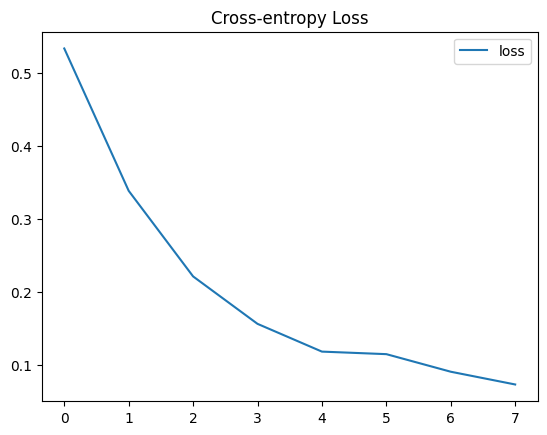

In [11]:
# Menampilkan nilai loss
history_df = pd.DataFrame(history)
history_df.loc[:, ['loss']].plot(title="Cross-entropy Loss")
history_df

In [12]:
model_ABSA = load_model(model_ABSA, model_name)

In [13]:
# Classification report
x, y = test_model_ABSA(test_loader)
print(classification_report(x, y, target_names=[str(i) for i in range(3)]))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       806
           1       0.89      0.89      0.89       808
           2       0.88      0.87      0.87       799

    accuracy                           0.90      2413
   macro avg       0.90      0.90      0.90      2413
weighted avg       0.90      0.90      0.90      2413

